## Imports

In [4]:
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers[torch]
!pip install tf-keras
!pip install "numpy<2.0"
!pip install -U kaleido

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [437]:
import os
import time

import csv
import pickle

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.colors as mcolors

print(np.__version__)

1.26.4


In [17]:
# Device configuration GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## VGG-16 Model


In [209]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Dataset

In [210]:
# Load CIFAR-100 dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [706]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

40000 10000 10000


In [14]:
for inputs, labels in train_loader:
    print(f"Input shape: {inputs.shape}, Labels: {labels.shape}")
    break

Input shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Base methods

In [10]:
num_classes = 10
config_1 = {
    "num_epochs": 50,
    "batch_size": 128,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "scheduler": {
        "type": "StepLR",
        "step_size": 15,
        "gamma": 0.1
    }
}

config_2 = {
    "num_epochs": 40,
    "batch_size": 64,
    "learning_rate": 0.01,
    "optimizer": "SGD",
    "momentum": 0.9,
    "scheduler": {
        "type": "CosineAnnealingLR",
        "T_max": 40
    }
}

config_3 = {
    "num_epochs": 100,
    "batch_size": 32,
    "learning_rate": 0.005,
    "optimizer": "Adam",
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "mode": "min",
        "factor": 0.1,
        "patience": 10
    },
    "regularization": {
        "dropout_rate": 0.5
    }
}

def config_test(selected_config):
    num_epochs = selected_config["num_epochs"]
    batch_size = selected_config["batch_size"]
    learning_rate = selected_config["learning_rate"]

    model = VGG16(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if selected_config["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif selected_config["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=selected_config.get("momentum", 0))

    if selected_config["scheduler"]["type"] == "StepLR":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=selected_config["scheduler"]["step_size"],
            gamma=selected_config["scheduler"]["gamma"]
        )
    elif selected_config["scheduler"]["type"] == "CosineAnnealingLR":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=selected_config["scheduler"]["T_max"]
        )
    elif selected_config["scheduler"]["type"] == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=selected_config["scheduler"]["mode"],
            factor=selected_config["scheduler"]["factor"],
            patience=selected_config["scheduler"]["patience"]
        )

    return num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler


In [ ]:
def load_model(model_path, num_classes=10):
    model = VGG16(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

In [218]:
def validate(model, dataloader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, total=len(dataloader), desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(dataloader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy
    

In [20]:
def train(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler, learning_rate=1.5, batch_size=10):
    total_step = len(train_loader)
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
    
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
    
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
    
          optimizer.step()
    
          running_loss += loss.item()
          if i % 100 == 199:  # Print every 100 mini-batches
              print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
              running_loss = 0.0
    
      # Validate the model
      val_loss , val_accuracy = validate(model, val_loader)
      print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
      scheduler.step()
    
    return model
    

In [19]:
def calculate_accuracy(model, dataloader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

## Training Original VGG16

### Test 1

In [ ]:
num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler = config_test(config_1)
model = train(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler)
torch.save(model.state_dict(), "model_t1.pth")

In [ ]:
accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

### Test 2

In [ ]:
num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler = config_test(config_2)
model = train(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler)
torch.save(model.state_dict(), "model_t2.h5")

In [ ]:
accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

### Test 3

In [ ]:
num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler = config_test(config_3)
model = train(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler)
torch.save(model.state_dict(), "model_t3.pth")

In [ ]:
accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

### Training Pruned VGG16

### Pruning methods

In [ ]:
def apply_pruning(model, conv_layers_, pruning_method, amount, structured=False):
  model.to(device)
  model.train()
  for name, layer in conv_layers_:
    if isinstance(layer, nn.Conv2d):
        if structured:
            if pruning_method == 'l1_structured':
                prune.ln_structured(layer, name='weight', amount=amount, n=1, dim=0)  # Prune output channels
                print(f"Applied L1 Structured pruning to layer: {name}")
            elif pruning_method == 'l2_structured':
                prune.ln_structured(layer, name='weight', amount=amount, n=2, dim=0)
                print(f"Applied L2 Structured pruning to layer: {name}")
            elif pruning_method == 'random_structured':
                prune.random_structured(layer, name='weight', amount=amount, dim=0)
                print(f"Applied Random Structured pruning to layer: {name}")
            else:
                raise ValueError(f"Unsupported structured pruning method: {pruning_method}")
        else:
            if pruning_method == 'l1_unstructured':
                prune.l1_unstructured(layer, name='weight', amount=amount)
                print(f"Applied L1 Unstructured pruning to layer: {name}")
            elif pruning_method == 'random_unstructured':
                prune.random_unstructured(layer, name='weight', amount=amount)
                print(f"Applied Random Unstructured pruning to layer: {name}")
            else:
                raise ValueError(f"Unsupported unstructured pruning method: {pruning_method}")

  return model


In [ ]:
def enforce_pruning_masks(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, 'weight_mask'):
                module.weight.data.mul_(module.weight_mask)


In [ ]:
def get_conv_layers(model):
    conv_layers = []
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
    return conv_layers


In [24]:
def load_model_with_masks(model, file_path):
    state_with_masks = torch.load(file_path, map_location=device)
    
    model.load_state_dict(state_with_masks, strict=False)
    model.to(device)

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            mask_key = f"{name}.weight_mask"
            if mask_key in state_with_masks:
                mask = state_with_masks[mask_key].to(device)
                prune.custom_from_mask(module, name='weight', mask=mask)
            else:
                print(f"Máscara não encontrada para {name}. Verifique o arquivo salvo.")

    return model


def check_pruning_applied(model):
    pruned_layers = []
    unpruned_layers = []

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, 'weight_orig'):
                pruned_layers.append(name)
            else:
                unpruned_layers.append(name)
    
    return pruned_layers, unpruned_layers
    

def save_model_with_masks(model, file_path):
    state_with_masks = model.state_dict()
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, 'weight_mask'):
                state_with_masks[f"{name}.weight_mask"] = module.weight_mask

    torch.save(state_with_masks, file_path)


In [219]:
def check_pruning_applied(model):
    pruned_layers = []
    unpruned_layers = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and hasattr(module, 'weight_orig'):
            pruned_layers.append(name)
            print(f"orig: Máscara na camada {name}:")
        if isinstance(module, nn.Conv2d) and hasattr(module, 'weight_mask'):
            print(f"mask: Máscara na camada {name}:")
        else:
            unpruned_layers.append(name)
    
    return pruned_layers, unpruned_layers

In [25]:
models_path = "models/"

In [ ]:
pruning_methods_all = ['l1_structured', 'l2_structured', 'random_structured', 'l1_unstructured', 'random_unstructured']
pruning_methods_structured = ['l1_structured', 'l2_structured', 'random_structured']
pruning_methods_unstructured = ['l1_unstructured', 'random_unstructured']

#### Pruning Conv2d layers - 10%

In [ ]:
for method in pruning_methods_all:
    model = load_model("/content/model_t2.h5")
    
    conv_layers = get_conv_layers(model)
    if method in pruning_methods_structured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.1, structured=True)
    elif method in pruning_methods_unstructured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.1, structured=False)
    
    save_model_with_masks(model, f'{models_path}vgg16_pruned_allConv2dlayers_{method}_0.1_with_masks.pth')


#### Pruning Conv2d layers - 20%

In [ ]:
for method in pruning_methods_all:
    model = load_model("/content/model_t2.h5")
    
    conv_layers = get_conv_layers(model)
    if method in pruning_methods_structured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.2, structured=True)
    elif method in pruning_methods_unstructured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.2, structured=False)
    
    torch.save(model.state_dict(), f'vgg16_pruned_allConv2dlayers_{method}_0.2.pth')
    save_model_with_masks(model, f'vgg16_pruned_allConv2dlayers_{method}_0.1_with_masks.pth')


#### Pruning Conv2d layers - 30%

In [ ]:
for method in pruning_methods_all:
    model = load_model("/content/model_t2.h5")
    
    conv_layers = get_conv_layers(model)
    if method in pruning_methods_structured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.3, structured=True)
    elif method in pruning_methods_unstructured:
        apply_pruning(model, conv_layers, pruning_method=f"{method}", amount=0.3, structured=False)
    
    torch.save(model.state_dict(), f'vgg16_pruned_allConv2dlayers_{method}_0.3.pth')

#### Fine Tune models for comparison

In [217]:
torch.cuda.empty_cache()
def get_models_buffer(path=None):
    models_buffer = {}
    
    pruning_methods_all = ['l1_structured', 'l2_structured', 'random_structured', 'l1_unstructured', 'random_unstructured']
    
    for method in pruning_methods_all:
      for percentage in [0.1, 0.2, 0.3]:
        model = load_model("model_t2.h5")
        model.to(device)
        if path:
            models_buffer[path] = load_model_with_masks(model, f"{models_folder}/vgg16_pruned_allConv2dlayers_{method}_{percentage}.pth")
        else:
            models_buffer[f"vgg16_pruned_allConv2dlayers_{method}_{percentage}"] = load_model_with_masks(model, f"{models_folder}/vgg16_pruned_allConv2dlayers_{method}_{percentage}.pth")
    return models_buffer

In [26]:
def finetune(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler, pruned_model_name, learning_rate, batch_size=10):
    total_step = len(train_loader)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    logs = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para GPU

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            
            if i % 100 == 199:
                avg_loss = running_loss / 100
                logs.append({
                    "epoch": epoch + 1,
                    "step": i + 1,
                    "train_loss": avg_loss
                })
                running_loss = 0.0

        val_loss, val_accuracy = validate(model, val_loader)
        logs.append({
            "epoch": epoch + 1,
            "validation_loss": val_loss,
            "validation_accuracy": val_accuracy
        })
        model.train()
        scheduler.step()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        with open(f"logs_pruning_finetune/logs_{pruned_model_name}.csv", "w", newline="") as csvfile:
            fieldnames = ["epoch", "validation_loss", "validation_accuracy"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
            writer.writeheader()
            for log in logs:
                writer.writerow(log)

    pruned_layers, unpruned_layers = check_pruning_applied(model)
    print(f"Após o treinamento: Camadas podadas ({len(pruned_layers)}): {pruned_layers}")
    print(f"Camadas não podadas ({len(unpruned_layers)}): {unpruned_layers}")

    return model


In [27]:
models_folder = "models_pruned_with_mask"

In [27]:
num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler = config_test(config_2)
models_buffer = get_models_buffer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for pruned_model_name in models_buffer.keys():
    print(f"\nTreinando o modelo: {pruned_model_name}")
    model = models_buffer[pruned_model_name].to(device)

    pruned_finetuned_model = finetune(train_loader, val_loader, num_epochs, model, criterion, optimizer, scheduler, pruned_model_name, learning_rate)

    for layer in pruned_finetuned_model.modules():
        if isinstance(layer, nn.Conv2d) and hasattr(layer, 'weight_orig'):
            prune.remove(layer, 'weight')
            print(f"Pruning removido da camada {layer}.")
        else:
            print(f"Camada {layer} não possui pruning para remover.")

    torch.save(pruned_finetuned_model.state_dict(), f"models/pruning_finetuned/{pruned_model_name}_finetuned_frozen.pth")


Treinando o modelo: vgg16_pruned_allConv2dlayers_l1_structured_0.1


100%|██████████| 157/157 [00:05<00:00, 29.33it/s]
/apps/conda/wesley.costa/.envs/constai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/40], Validation Loss: 0.5553, Validation Accuracy: 81.72%


100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch [2/40], Validation Loss: 0.4497, Validation Accuracy: 85.27%


100%|██████████| 157/157 [00:05<00:00, 26.95it/s]


Epoch [3/40], Validation Loss: 0.4579, Validation Accuracy: 84.70%


100%|██████████| 157/157 [00:05<00:00, 29.72it/s]


Epoch [4/40], Validation Loss: 0.3895, Validation Accuracy: 86.75%


100%|██████████| 157/157 [00:05<00:00, 28.56it/s]


Epoch [5/40], Validation Loss: 0.3935, Validation Accuracy: 86.86%


100%|██████████| 157/157 [00:05<00:00, 28.78it/s]


Epoch [6/40], Validation Loss: 0.3921, Validation Accuracy: 86.96%


100%|██████████| 157/157 [00:05<00:00, 29.21it/s]


Epoch [7/40], Validation Loss: 0.3933, Validation Accuracy: 86.87%


100%|██████████| 157/157 [00:05<00:00, 29.74it/s]


Epoch [8/40], Validation Loss: 0.3424, Validation Accuracy: 88.46%


100%|██████████| 157/157 [00:05<00:00, 28.94it/s]


Epoch [9/40], Validation Loss: 0.3640, Validation Accuracy: 87.96%


100%|██████████| 157/157 [00:05<00:00, 27.99it/s]


Epoch [10/40], Validation Loss: 0.3420, Validation Accuracy: 88.57%


100%|██████████| 157/157 [00:05<00:00, 30.13it/s]


Epoch [11/40], Validation Loss: 0.3530, Validation Accuracy: 88.56%


100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


Epoch [12/40], Validation Loss: 0.3536, Validation Accuracy: 88.62%


100%|██████████| 157/157 [00:05<00:00, 30.03it/s]


Epoch [13/40], Validation Loss: 0.3626, Validation Accuracy: 87.85%


100%|██████████| 157/157 [00:05<00:00, 29.33it/s]


Epoch [14/40], Validation Loss: 0.3350, Validation Accuracy: 89.15%


100%|██████████| 157/157 [00:05<00:00, 27.00it/s]


Epoch [15/40], Validation Loss: 0.3545, Validation Accuracy: 88.59%


100%|██████████| 157/157 [00:04<00:00, 31.59it/s]


Epoch [16/40], Validation Loss: 0.3931, Validation Accuracy: 87.38%


100%|██████████| 157/157 [00:04<00:00, 31.88it/s]


Epoch [17/40], Validation Loss: 0.3390, Validation Accuracy: 88.72%


100%|██████████| 157/157 [00:05<00:00, 30.23it/s]


Epoch [18/40], Validation Loss: 0.3256, Validation Accuracy: 89.12%


100%|██████████| 157/157 [00:05<00:00, 29.11it/s]


Epoch [19/40], Validation Loss: 0.3366, Validation Accuracy: 88.91%


100%|██████████| 157/157 [00:04<00:00, 31.51it/s]


Epoch [20/40], Validation Loss: 0.3692, Validation Accuracy: 88.36%


100%|██████████| 157/157 [00:05<00:00, 31.32it/s]


Epoch [21/40], Validation Loss: 0.3115, Validation Accuracy: 89.41%


100%|██████████| 157/157 [00:05<00:00, 31.10it/s]


Epoch [22/40], Validation Loss: 0.3386, Validation Accuracy: 89.74%


100%|██████████| 157/157 [00:04<00:00, 31.98it/s]


Epoch [23/40], Validation Loss: 0.3310, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:05<00:00, 30.85it/s]


Epoch [24/40], Validation Loss: 0.3399, Validation Accuracy: 89.04%


100%|██████████| 157/157 [00:05<00:00, 30.79it/s]


Epoch [25/40], Validation Loss: 0.3142, Validation Accuracy: 89.66%


100%|██████████| 157/157 [00:05<00:00, 30.01it/s]


Epoch [26/40], Validation Loss: 0.3450, Validation Accuracy: 89.06%


100%|██████████| 157/157 [00:04<00:00, 32.09it/s]


Epoch [27/40], Validation Loss: 0.3360, Validation Accuracy: 89.54%


100%|██████████| 157/157 [00:05<00:00, 30.20it/s]


Epoch [28/40], Validation Loss: 0.3179, Validation Accuracy: 90.11%


100%|██████████| 157/157 [00:05<00:00, 28.86it/s]


Epoch [29/40], Validation Loss: 0.3322, Validation Accuracy: 89.68%


100%|██████████| 157/157 [00:05<00:00, 29.89it/s]


Epoch [30/40], Validation Loss: 0.3395, Validation Accuracy: 89.84%


100%|██████████| 157/157 [00:05<00:00, 29.26it/s]


Epoch [31/40], Validation Loss: 0.3538, Validation Accuracy: 88.97%


100%|██████████| 157/157 [00:05<00:00, 29.86it/s]


Epoch [32/40], Validation Loss: 0.3382, Validation Accuracy: 89.49%


100%|██████████| 157/157 [00:05<00:00, 30.05it/s]


Epoch [33/40], Validation Loss: 0.3380, Validation Accuracy: 90.12%


100%|██████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch [34/40], Validation Loss: 0.3701, Validation Accuracy: 89.14%


100%|██████████| 157/157 [00:05<00:00, 30.82it/s]


Epoch [35/40], Validation Loss: 0.3545, Validation Accuracy: 89.47%


100%|██████████| 157/157 [00:05<00:00, 30.22it/s]


Epoch [36/40], Validation Loss: 0.3323, Validation Accuracy: 89.90%


100%|██████████| 157/157 [00:05<00:00, 30.77it/s]


Epoch [37/40], Validation Loss: 0.3351, Validation Accuracy: 90.14%


100%|██████████| 157/157 [00:05<00:00, 28.50it/s]


Epoch [38/40], Validation Loss: 0.3347, Validation Accuracy: 90.10%


100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Epoch [39/40], Validation Loss: 0.3593, Validation Accuracy: 89.50%


100%|██████████| 157/157 [00:05<00:00, 28.88it/s]


Epoch [40/40], Validation Loss: 0.3638, Validation Accuracy: 88.82%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 30.64it/s]


Epoch [1/40], Validation Loss: 0.5401, Validation Accuracy: 81.59%


100%|██████████| 157/157 [00:05<00:00, 28.77it/s]


Epoch [2/40], Validation Loss: 0.4988, Validation Accuracy: 83.52%


100%|██████████| 157/157 [00:05<00:00, 29.38it/s]


Epoch [3/40], Validation Loss: 0.4876, Validation Accuracy: 84.13%


100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


Epoch [4/40], Validation Loss: 0.4760, Validation Accuracy: 84.39%


100%|██████████| 157/157 [00:05<00:00, 29.93it/s]


Epoch [5/40], Validation Loss: 0.4463, Validation Accuracy: 85.25%


100%|██████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch [6/40], Validation Loss: 0.3938, Validation Accuracy: 86.97%


100%|██████████| 157/157 [00:04<00:00, 31.66it/s]


Epoch [7/40], Validation Loss: 0.4131, Validation Accuracy: 85.86%


100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


Epoch [8/40], Validation Loss: 0.3688, Validation Accuracy: 87.48%


100%|██████████| 157/157 [00:04<00:00, 31.73it/s]


Epoch [9/40], Validation Loss: 0.4186, Validation Accuracy: 86.37%


100%|██████████| 157/157 [00:04<00:00, 32.00it/s]


Epoch [10/40], Validation Loss: 0.3695, Validation Accuracy: 88.04%


100%|██████████| 157/157 [00:05<00:00, 31.17it/s]


Epoch [11/40], Validation Loss: 0.3564, Validation Accuracy: 88.06%


100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


Epoch [12/40], Validation Loss: 0.3393, Validation Accuracy: 88.67%


100%|██████████| 157/157 [00:04<00:00, 31.58it/s]


Epoch [13/40], Validation Loss: 0.3830, Validation Accuracy: 87.95%


100%|██████████| 157/157 [00:05<00:00, 30.60it/s]


Epoch [14/40], Validation Loss: 0.3511, Validation Accuracy: 88.23%


100%|██████████| 157/157 [00:05<00:00, 29.04it/s]


Epoch [15/40], Validation Loss: 0.4088, Validation Accuracy: 86.77%


100%|██████████| 157/157 [00:05<00:00, 31.23it/s]


Epoch [16/40], Validation Loss: 0.3605, Validation Accuracy: 88.30%


100%|██████████| 157/157 [00:05<00:00, 31.38it/s]


Epoch [17/40], Validation Loss: 0.3319, Validation Accuracy: 88.68%


100%|██████████| 157/157 [00:04<00:00, 32.78it/s]


Epoch [18/40], Validation Loss: 0.3654, Validation Accuracy: 88.63%


100%|██████████| 157/157 [00:05<00:00, 29.97it/s]


Epoch [19/40], Validation Loss: 0.3453, Validation Accuracy: 88.85%


100%|██████████| 157/157 [00:04<00:00, 32.60it/s]


Epoch [20/40], Validation Loss: 0.3520, Validation Accuracy: 88.73%


100%|██████████| 157/157 [00:05<00:00, 30.47it/s]


Epoch [21/40], Validation Loss: 0.3259, Validation Accuracy: 89.15%


100%|██████████| 157/157 [00:05<00:00, 30.99it/s]


Epoch [22/40], Validation Loss: 0.3598, Validation Accuracy: 88.60%


100%|██████████| 157/157 [00:04<00:00, 31.93it/s]


Epoch [23/40], Validation Loss: 0.3295, Validation Accuracy: 89.61%


100%|██████████| 157/157 [00:04<00:00, 31.54it/s]


Epoch [24/40], Validation Loss: 0.3325, Validation Accuracy: 88.93%


100%|██████████| 157/157 [00:05<00:00, 31.17it/s]


Epoch [25/40], Validation Loss: 0.3478, Validation Accuracy: 89.14%


100%|██████████| 157/157 [00:05<00:00, 30.48it/s]


Epoch [26/40], Validation Loss: 0.3154, Validation Accuracy: 89.58%


100%|██████████| 157/157 [00:05<00:00, 29.52it/s]


Epoch [27/40], Validation Loss: 0.3506, Validation Accuracy: 89.51%


100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Epoch [28/40], Validation Loss: 0.3539, Validation Accuracy: 88.80%


100%|██████████| 157/157 [00:04<00:00, 33.68it/s]


Epoch [29/40], Validation Loss: 0.3714, Validation Accuracy: 88.41%


100%|██████████| 157/157 [00:05<00:00, 31.09it/s]


Epoch [30/40], Validation Loss: 0.3511, Validation Accuracy: 88.88%


100%|██████████| 157/157 [00:04<00:00, 31.89it/s]


Epoch [31/40], Validation Loss: 0.3425, Validation Accuracy: 89.11%


100%|██████████| 157/157 [00:05<00:00, 30.83it/s]


Epoch [32/40], Validation Loss: 0.3412, Validation Accuracy: 89.50%


100%|██████████| 157/157 [00:05<00:00, 31.04it/s]


Epoch [33/40], Validation Loss: 0.3563, Validation Accuracy: 89.09%


100%|██████████| 157/157 [00:04<00:00, 32.21it/s]


Epoch [34/40], Validation Loss: 0.3515, Validation Accuracy: 89.36%


100%|██████████| 157/157 [00:04<00:00, 32.25it/s]


Epoch [35/40], Validation Loss: 0.3314, Validation Accuracy: 89.63%


100%|██████████| 157/157 [00:04<00:00, 32.25it/s]


Epoch [36/40], Validation Loss: 0.3340, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:04<00:00, 32.37it/s]


Epoch [37/40], Validation Loss: 0.3364, Validation Accuracy: 90.05%


100%|██████████| 157/157 [00:05<00:00, 29.95it/s]


Epoch [38/40], Validation Loss: 0.3301, Validation Accuracy: 90.26%


100%|██████████| 157/157 [00:04<00:00, 31.56it/s]


Epoch [39/40], Validation Loss: 0.3362, Validation Accuracy: 90.25%


100%|██████████| 157/157 [00:04<00:00, 31.58it/s]


Epoch [40/40], Validation Loss: 0.3597, Validation Accuracy: 89.44%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:04<00:00, 32.61it/s]


Epoch [1/40], Validation Loss: 0.6328, Validation Accuracy: 79.10%


100%|██████████| 157/157 [00:05<00:00, 30.51it/s]


Epoch [2/40], Validation Loss: 0.4945, Validation Accuracy: 83.48%


100%|██████████| 157/157 [00:04<00:00, 31.88it/s]


Epoch [3/40], Validation Loss: 0.4877, Validation Accuracy: 83.19%


100%|██████████| 157/157 [00:04<00:00, 31.40it/s]


Epoch [4/40], Validation Loss: 0.4614, Validation Accuracy: 85.02%


100%|██████████| 157/157 [00:05<00:00, 30.72it/s]


Epoch [5/40], Validation Loss: 0.4181, Validation Accuracy: 86.33%


100%|██████████| 157/157 [00:04<00:00, 33.12it/s]


Epoch [6/40], Validation Loss: 0.4490, Validation Accuracy: 84.83%


100%|██████████| 157/157 [00:05<00:00, 30.75it/s]


Epoch [7/40], Validation Loss: 0.4022, Validation Accuracy: 86.72%


100%|██████████| 157/157 [00:04<00:00, 33.41it/s]


Epoch [8/40], Validation Loss: 0.4108, Validation Accuracy: 86.03%


100%|██████████| 157/157 [00:05<00:00, 30.58it/s]


Epoch [9/40], Validation Loss: 0.3866, Validation Accuracy: 87.24%


100%|██████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch [10/40], Validation Loss: 0.4280, Validation Accuracy: 86.09%


100%|██████████| 157/157 [00:04<00:00, 33.42it/s]


Epoch [11/40], Validation Loss: 0.3522, Validation Accuracy: 88.49%


100%|██████████| 157/157 [00:04<00:00, 31.96it/s]


Epoch [12/40], Validation Loss: 0.3840, Validation Accuracy: 87.07%


100%|██████████| 157/157 [00:05<00:00, 27.84it/s]


Epoch [13/40], Validation Loss: 0.3918, Validation Accuracy: 86.98%


100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


Epoch [14/40], Validation Loss: 0.3682, Validation Accuracy: 87.72%


100%|██████████| 157/157 [00:05<00:00, 30.35it/s]


Epoch [15/40], Validation Loss: 0.3734, Validation Accuracy: 87.73%


100%|██████████| 157/157 [00:05<00:00, 27.98it/s]


Epoch [16/40], Validation Loss: 0.3567, Validation Accuracy: 88.10%


100%|██████████| 157/157 [00:05<00:00, 29.22it/s]


Epoch [17/40], Validation Loss: 0.3567, Validation Accuracy: 88.27%


100%|██████████| 157/157 [00:05<00:00, 28.60it/s]


Epoch [18/40], Validation Loss: 0.3408, Validation Accuracy: 88.59%


100%|██████████| 157/157 [00:05<00:00, 30.40it/s]


Epoch [19/40], Validation Loss: 0.3383, Validation Accuracy: 88.63%


100%|██████████| 157/157 [00:05<00:00, 29.30it/s]


Epoch [20/40], Validation Loss: 0.3489, Validation Accuracy: 88.72%


100%|██████████| 157/157 [00:05<00:00, 29.93it/s]


Epoch [21/40], Validation Loss: 0.3436, Validation Accuracy: 88.70%


100%|██████████| 157/157 [00:05<00:00, 29.47it/s]


Epoch [22/40], Validation Loss: 0.3332, Validation Accuracy: 89.01%


100%|██████████| 157/157 [00:05<00:00, 30.29it/s]


Epoch [23/40], Validation Loss: 0.3641, Validation Accuracy: 88.48%


100%|██████████| 157/157 [00:05<00:00, 29.01it/s]


Epoch [24/40], Validation Loss: 0.3698, Validation Accuracy: 87.96%


100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch [25/40], Validation Loss: 0.3533, Validation Accuracy: 88.36%


100%|██████████| 157/157 [00:05<00:00, 30.45it/s]


Epoch [26/40], Validation Loss: 0.3365, Validation Accuracy: 89.08%


100%|██████████| 157/157 [00:05<00:00, 28.37it/s]


Epoch [27/40], Validation Loss: 0.3557, Validation Accuracy: 88.85%


100%|██████████| 157/157 [00:05<00:00, 29.51it/s]


Epoch [28/40], Validation Loss: 0.3236, Validation Accuracy: 89.57%


100%|██████████| 157/157 [00:04<00:00, 31.64it/s]


Epoch [29/40], Validation Loss: 0.3413, Validation Accuracy: 88.80%


100%|██████████| 157/157 [00:04<00:00, 32.08it/s]


Epoch [30/40], Validation Loss: 0.3428, Validation Accuracy: 88.89%


100%|██████████| 157/157 [00:04<00:00, 32.07it/s]


Epoch [31/40], Validation Loss: 0.3541, Validation Accuracy: 88.97%


100%|██████████| 157/157 [00:05<00:00, 28.16it/s]


Epoch [32/40], Validation Loss: 0.3687, Validation Accuracy: 88.54%


100%|██████████| 157/157 [00:04<00:00, 31.43it/s]


Epoch [33/40], Validation Loss: 0.3501, Validation Accuracy: 89.27%


100%|██████████| 157/157 [00:05<00:00, 31.25it/s]


Epoch [34/40], Validation Loss: 0.3528, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:04<00:00, 32.21it/s]


Epoch [35/40], Validation Loss: 0.3640, Validation Accuracy: 88.93%


100%|██████████| 157/157 [00:04<00:00, 32.79it/s]


Epoch [36/40], Validation Loss: 0.3427, Validation Accuracy: 89.68%


100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Epoch [37/40], Validation Loss: 0.3592, Validation Accuracy: 89.50%


100%|██████████| 157/157 [00:04<00:00, 32.51it/s]


Epoch [38/40], Validation Loss: 0.3546, Validation Accuracy: 89.35%


100%|██████████| 157/157 [00:04<00:00, 32.82it/s]


Epoch [39/40], Validation Loss: 0.3471, Validation Accuracy: 89.47%


100%|██████████| 157/157 [00:04<00:00, 31.56it/s]


Epoch [40/40], Validation Loss: 0.3530, Validation Accuracy: 89.23%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Epoch [1/40], Validation Loss: 0.5165, Validation Accuracy: 83.21%


100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch [2/40], Validation Loss: 0.4671, Validation Accuracy: 84.02%


100%|██████████| 157/157 [00:05<00:00, 29.18it/s]


Epoch [3/40], Validation Loss: 0.3909, Validation Accuracy: 87.04%


100%|██████████| 157/157 [00:05<00:00, 30.26it/s]


Epoch [4/40], Validation Loss: 0.4315, Validation Accuracy: 85.59%


100%|██████████| 157/157 [00:05<00:00, 31.24it/s]


Epoch [5/40], Validation Loss: 0.3893, Validation Accuracy: 87.17%


100%|██████████| 157/157 [00:04<00:00, 33.27it/s]


Epoch [6/40], Validation Loss: 0.3676, Validation Accuracy: 87.71%


100%|██████████| 157/157 [00:04<00:00, 32.22it/s]


Epoch [7/40], Validation Loss: 0.3714, Validation Accuracy: 87.46%


100%|██████████| 157/157 [00:05<00:00, 29.54it/s]


Epoch [8/40], Validation Loss: 0.3596, Validation Accuracy: 88.02%


100%|██████████| 157/157 [00:05<00:00, 28.27it/s]


Epoch [9/40], Validation Loss: 0.3592, Validation Accuracy: 88.12%


100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch [10/40], Validation Loss: 0.4022, Validation Accuracy: 86.89%


100%|██████████| 157/157 [00:05<00:00, 27.72it/s]


Epoch [11/40], Validation Loss: 0.3432, Validation Accuracy: 88.41%


100%|██████████| 157/157 [00:05<00:00, 30.04it/s]


Epoch [12/40], Validation Loss: 0.3819, Validation Accuracy: 87.44%


100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


Epoch [13/40], Validation Loss: 0.3801, Validation Accuracy: 87.76%


100%|██████████| 157/157 [00:05<00:00, 27.42it/s]


Epoch [14/40], Validation Loss: 0.3248, Validation Accuracy: 89.29%


100%|██████████| 157/157 [00:05<00:00, 29.67it/s]


Epoch [15/40], Validation Loss: 0.3404, Validation Accuracy: 88.95%


100%|██████████| 157/157 [00:05<00:00, 27.46it/s]


Epoch [16/40], Validation Loss: 0.3330, Validation Accuracy: 88.88%


100%|██████████| 157/157 [00:05<00:00, 30.52it/s]


Epoch [17/40], Validation Loss: 0.3580, Validation Accuracy: 88.34%


100%|██████████| 157/157 [00:04<00:00, 33.33it/s]


Epoch [18/40], Validation Loss: 0.4080, Validation Accuracy: 87.32%


100%|██████████| 157/157 [00:05<00:00, 30.07it/s]


Epoch [19/40], Validation Loss: 0.3593, Validation Accuracy: 88.52%


100%|██████████| 157/157 [00:05<00:00, 29.14it/s]


Epoch [20/40], Validation Loss: 0.3185, Validation Accuracy: 89.19%


100%|██████████| 157/157 [00:05<00:00, 29.31it/s]


Epoch [21/40], Validation Loss: 0.3226, Validation Accuracy: 89.50%


100%|██████████| 157/157 [00:05<00:00, 29.00it/s]


Epoch [22/40], Validation Loss: 0.3255, Validation Accuracy: 89.52%


100%|██████████| 157/157 [00:05<00:00, 29.34it/s]


Epoch [23/40], Validation Loss: 0.3282, Validation Accuracy: 89.36%


100%|██████████| 157/157 [00:05<00:00, 30.00it/s]


Epoch [24/40], Validation Loss: 0.3676, Validation Accuracy: 88.30%


100%|██████████| 157/157 [00:05<00:00, 29.09it/s]


Epoch [25/40], Validation Loss: 0.3350, Validation Accuracy: 89.22%


100%|██████████| 157/157 [00:05<00:00, 28.84it/s]


Epoch [26/40], Validation Loss: 0.3268, Validation Accuracy: 89.54%


100%|██████████| 157/157 [00:05<00:00, 28.87it/s]


Epoch [27/40], Validation Loss: 0.3201, Validation Accuracy: 90.11%


100%|██████████| 157/157 [00:05<00:00, 28.73it/s]


Epoch [28/40], Validation Loss: 0.3366, Validation Accuracy: 89.46%


100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Epoch [29/40], Validation Loss: 0.3376, Validation Accuracy: 89.85%


100%|██████████| 157/157 [00:05<00:00, 28.16it/s]


Epoch [30/40], Validation Loss: 0.3411, Validation Accuracy: 89.43%


100%|██████████| 157/157 [00:05<00:00, 28.06it/s]


Epoch [31/40], Validation Loss: 0.3388, Validation Accuracy: 89.78%


100%|██████████| 157/157 [00:05<00:00, 31.08it/s]


Epoch [32/40], Validation Loss: 0.3571, Validation Accuracy: 89.40%


100%|██████████| 157/157 [00:05<00:00, 28.15it/s]


Epoch [33/40], Validation Loss: 0.3121, Validation Accuracy: 90.21%


100%|██████████| 157/157 [00:05<00:00, 30.29it/s]


Epoch [34/40], Validation Loss: 0.3182, Validation Accuracy: 90.18%


100%|██████████| 157/157 [00:05<00:00, 30.60it/s]


Epoch [35/40], Validation Loss: 0.3640, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:05<00:00, 29.77it/s]


Epoch [36/40], Validation Loss: 0.3330, Validation Accuracy: 90.23%


100%|██████████| 157/157 [00:05<00:00, 29.99it/s]


Epoch [37/40], Validation Loss: 0.3349, Validation Accuracy: 90.01%


100%|██████████| 157/157 [00:05<00:00, 29.35it/s]


Epoch [38/40], Validation Loss: 0.3401, Validation Accuracy: 90.34%


100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch [39/40], Validation Loss: 0.3293, Validation Accuracy: 90.20%


100%|██████████| 157/157 [00:05<00:00, 31.14it/s]


Epoch [40/40], Validation Loss: 0.3311, Validation Accuracy: 89.96%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 28.56it/s]


Epoch [1/40], Validation Loss: 0.5507, Validation Accuracy: 82.05%


100%|██████████| 157/157 [00:05<00:00, 27.99it/s]


Epoch [2/40], Validation Loss: 0.5078, Validation Accuracy: 82.95%


100%|██████████| 157/157 [00:05<00:00, 29.24it/s]


Epoch [3/40], Validation Loss: 0.5363, Validation Accuracy: 82.56%


100%|██████████| 157/157 [00:05<00:00, 27.16it/s]


Epoch [4/40], Validation Loss: 0.4236, Validation Accuracy: 85.77%


100%|██████████| 157/157 [00:05<00:00, 29.53it/s]


Epoch [5/40], Validation Loss: 0.3936, Validation Accuracy: 86.97%


100%|██████████| 157/157 [00:05<00:00, 29.59it/s]


Epoch [6/40], Validation Loss: 0.4000, Validation Accuracy: 86.61%


100%|██████████| 157/157 [00:05<00:00, 29.88it/s]


Epoch [7/40], Validation Loss: 0.3635, Validation Accuracy: 88.32%


100%|██████████| 157/157 [00:05<00:00, 29.13it/s]


Epoch [8/40], Validation Loss: 0.3806, Validation Accuracy: 87.40%


100%|██████████| 157/157 [00:05<00:00, 30.07it/s]


Epoch [9/40], Validation Loss: 0.4038, Validation Accuracy: 86.70%


100%|██████████| 157/157 [00:05<00:00, 30.84it/s]


Epoch [10/40], Validation Loss: 0.3698, Validation Accuracy: 87.83%


100%|██████████| 157/157 [00:05<00:00, 28.38it/s]


Epoch [11/40], Validation Loss: 0.3682, Validation Accuracy: 87.78%


100%|██████████| 157/157 [00:05<00:00, 30.14it/s]


Epoch [12/40], Validation Loss: 0.3613, Validation Accuracy: 87.87%


100%|██████████| 157/157 [00:05<00:00, 29.30it/s]


Epoch [13/40], Validation Loss: 0.3427, Validation Accuracy: 88.65%


100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


Epoch [14/40], Validation Loss: 0.3530, Validation Accuracy: 88.37%


100%|██████████| 157/157 [00:04<00:00, 32.99it/s]


Epoch [15/40], Validation Loss: 0.3794, Validation Accuracy: 87.77%


100%|██████████| 157/157 [00:05<00:00, 30.18it/s]


Epoch [16/40], Validation Loss: 0.3616, Validation Accuracy: 88.06%


100%|██████████| 157/157 [00:04<00:00, 32.76it/s]


Epoch [17/40], Validation Loss: 0.3559, Validation Accuracy: 88.34%


100%|██████████| 157/157 [00:05<00:00, 29.91it/s]


Epoch [18/40], Validation Loss: 0.3586, Validation Accuracy: 88.47%


100%|██████████| 157/157 [00:04<00:00, 32.47it/s]


Epoch [19/40], Validation Loss: 0.3215, Validation Accuracy: 89.22%


100%|██████████| 157/157 [00:05<00:00, 31.28it/s]


Epoch [20/40], Validation Loss: 0.3486, Validation Accuracy: 88.81%


100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch [21/40], Validation Loss: 0.3330, Validation Accuracy: 88.91%


100%|██████████| 157/157 [00:05<00:00, 31.11it/s]


Epoch [22/40], Validation Loss: 0.3310, Validation Accuracy: 88.93%


100%|██████████| 157/157 [00:04<00:00, 32.03it/s]


Epoch [23/40], Validation Loss: 0.3501, Validation Accuracy: 88.57%


100%|██████████| 157/157 [00:04<00:00, 33.02it/s]


Epoch [24/40], Validation Loss: 0.3446, Validation Accuracy: 89.14%


100%|██████████| 157/157 [00:05<00:00, 30.66it/s]


Epoch [25/40], Validation Loss: 0.3276, Validation Accuracy: 89.40%


100%|██████████| 157/157 [00:05<00:00, 29.75it/s]


Epoch [26/40], Validation Loss: 0.3512, Validation Accuracy: 88.96%


100%|██████████| 157/157 [00:04<00:00, 33.31it/s]


Epoch [27/40], Validation Loss: 0.3322, Validation Accuracy: 89.46%


100%|██████████| 157/157 [00:05<00:00, 30.86it/s]


Epoch [28/40], Validation Loss: 0.3451, Validation Accuracy: 89.48%


100%|██████████| 157/157 [00:04<00:00, 31.50it/s]


Epoch [29/40], Validation Loss: 0.3315, Validation Accuracy: 89.25%


100%|██████████| 157/157 [00:04<00:00, 31.42it/s]


Epoch [30/40], Validation Loss: 0.3469, Validation Accuracy: 89.14%


100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Epoch [31/40], Validation Loss: 0.3589, Validation Accuracy: 88.87%


100%|██████████| 157/157 [00:04<00:00, 31.75it/s]


Epoch [32/40], Validation Loss: 0.3797, Validation Accuracy: 88.92%


100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Epoch [33/40], Validation Loss: 0.3374, Validation Accuracy: 89.98%


100%|██████████| 157/157 [00:04<00:00, 32.52it/s]


Epoch [34/40], Validation Loss: 0.3426, Validation Accuracy: 89.24%


100%|██████████| 157/157 [00:05<00:00, 30.03it/s]


Epoch [35/40], Validation Loss: 0.3267, Validation Accuracy: 90.05%


100%|██████████| 157/157 [00:04<00:00, 33.85it/s]


Epoch [36/40], Validation Loss: 0.3394, Validation Accuracy: 89.92%


100%|██████████| 157/157 [00:05<00:00, 31.09it/s]


Epoch [37/40], Validation Loss: 0.3627, Validation Accuracy: 89.15%


100%|██████████| 157/157 [00:04<00:00, 32.94it/s]


Epoch [38/40], Validation Loss: 0.3539, Validation Accuracy: 89.57%


100%|██████████| 157/157 [00:04<00:00, 33.46it/s]


Epoch [39/40], Validation Loss: 0.3475, Validation Accuracy: 89.98%


100%|██████████| 157/157 [00:04<00:00, 32.50it/s]


Epoch [40/40], Validation Loss: 0.3724, Validation Accuracy: 89.35%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:04<00:00, 32.15it/s]


Epoch [1/40], Validation Loss: 0.5387, Validation Accuracy: 82.09%


100%|██████████| 157/157 [00:05<00:00, 31.25it/s]


Epoch [2/40], Validation Loss: 0.5710, Validation Accuracy: 81.03%


100%|██████████| 157/157 [00:05<00:00, 30.07it/s]


Epoch [3/40], Validation Loss: 0.4945, Validation Accuracy: 83.42%


100%|██████████| 157/157 [00:05<00:00, 30.52it/s]


Epoch [4/40], Validation Loss: 0.5030, Validation Accuracy: 83.98%


100%|██████████| 157/157 [00:05<00:00, 31.10it/s]


Epoch [5/40], Validation Loss: 0.4253, Validation Accuracy: 85.64%


100%|██████████| 157/157 [00:04<00:00, 32.08it/s]


Epoch [6/40], Validation Loss: 0.5067, Validation Accuracy: 83.48%


100%|██████████| 157/157 [00:05<00:00, 30.83it/s]


Epoch [7/40], Validation Loss: 0.3772, Validation Accuracy: 87.76%


100%|██████████| 157/157 [00:05<00:00, 31.04it/s]


Epoch [8/40], Validation Loss: 0.3902, Validation Accuracy: 86.87%


100%|██████████| 157/157 [00:05<00:00, 30.70it/s]


Epoch [9/40], Validation Loss: 0.4239, Validation Accuracy: 85.67%


100%|██████████| 157/157 [00:04<00:00, 32.35it/s]


Epoch [10/40], Validation Loss: 0.3834, Validation Accuracy: 87.34%


100%|██████████| 157/157 [00:05<00:00, 30.85it/s]


Epoch [11/40], Validation Loss: 0.3993, Validation Accuracy: 86.81%


100%|██████████| 157/157 [00:05<00:00, 29.73it/s]


Epoch [12/40], Validation Loss: 0.3720, Validation Accuracy: 87.79%


100%|██████████| 157/157 [00:04<00:00, 32.31it/s]


Epoch [13/40], Validation Loss: 0.3585, Validation Accuracy: 88.00%


100%|██████████| 157/157 [00:04<00:00, 32.21it/s]


Epoch [14/40], Validation Loss: 0.3826, Validation Accuracy: 87.56%


100%|██████████| 157/157 [00:04<00:00, 31.59it/s]


Epoch [15/40], Validation Loss: 0.3532, Validation Accuracy: 88.23%


100%|██████████| 157/157 [00:04<00:00, 32.89it/s]


Epoch [16/40], Validation Loss: 0.3391, Validation Accuracy: 89.30%


100%|██████████| 157/157 [00:05<00:00, 31.20it/s]


Epoch [17/40], Validation Loss: 0.3765, Validation Accuracy: 87.34%


100%|██████████| 157/157 [00:05<00:00, 29.49it/s]


Epoch [18/40], Validation Loss: 0.3510, Validation Accuracy: 88.20%


100%|██████████| 157/157 [00:04<00:00, 33.31it/s]


Epoch [19/40], Validation Loss: 0.3382, Validation Accuracy: 89.03%


100%|██████████| 157/157 [00:04<00:00, 31.56it/s]


Epoch [20/40], Validation Loss: 0.3504, Validation Accuracy: 88.86%


100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Epoch [21/40], Validation Loss: 0.3536, Validation Accuracy: 88.55%


100%|██████████| 157/157 [00:04<00:00, 31.46it/s]


Epoch [22/40], Validation Loss: 0.3588, Validation Accuracy: 88.05%


100%|██████████| 157/157 [00:05<00:00, 31.05it/s]


Epoch [23/40], Validation Loss: 0.3572, Validation Accuracy: 88.28%


100%|██████████| 157/157 [00:05<00:00, 30.94it/s]


Epoch [24/40], Validation Loss: 0.3656, Validation Accuracy: 88.46%


100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


Epoch [25/40], Validation Loss: 0.3849, Validation Accuracy: 87.80%


100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Epoch [26/40], Validation Loss: 0.3607, Validation Accuracy: 88.13%


100%|██████████| 157/157 [00:04<00:00, 31.81it/s]


Epoch [27/40], Validation Loss: 0.3590, Validation Accuracy: 88.86%


100%|██████████| 157/157 [00:04<00:00, 33.01it/s]


Epoch [28/40], Validation Loss: 0.3554, Validation Accuracy: 88.72%


100%|██████████| 157/157 [00:05<00:00, 28.77it/s]


Epoch [29/40], Validation Loss: 0.3474, Validation Accuracy: 88.98%


100%|██████████| 157/157 [00:05<00:00, 29.87it/s]


Epoch [30/40], Validation Loss: 0.3518, Validation Accuracy: 88.74%


100%|██████████| 157/157 [00:05<00:00, 30.94it/s]


Epoch [31/40], Validation Loss: 0.3343, Validation Accuracy: 89.58%


100%|██████████| 157/157 [00:05<00:00, 30.84it/s]


Epoch [32/40], Validation Loss: 0.3865, Validation Accuracy: 88.31%


100%|██████████| 157/157 [00:05<00:00, 31.31it/s]


Epoch [33/40], Validation Loss: 0.3629, Validation Accuracy: 88.74%


100%|██████████| 157/157 [00:04<00:00, 32.51it/s]


Epoch [34/40], Validation Loss: 0.3390, Validation Accuracy: 89.57%


100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Epoch [35/40], Validation Loss: 0.3309, Validation Accuracy: 89.72%


100%|██████████| 157/157 [00:05<00:00, 30.40it/s]


Epoch [36/40], Validation Loss: 0.3898, Validation Accuracy: 88.41%


100%|██████████| 157/157 [00:04<00:00, 32.45it/s]


Epoch [37/40], Validation Loss: 0.3582, Validation Accuracy: 89.31%


100%|██████████| 157/157 [00:04<00:00, 32.89it/s]


Epoch [38/40], Validation Loss: 0.3504, Validation Accuracy: 89.30%


100%|██████████| 157/157 [00:05<00:00, 30.93it/s]


Epoch [39/40], Validation Loss: 0.3501, Validation Accuracy: 89.41%


100%|██████████| 157/157 [00:05<00:00, 31.19it/s]


Epoch [40/40], Validation Loss: 0.3513, Validation Accuracy: 88.80%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 30.49it/s]


Epoch [1/40], Validation Loss: 0.6889, Validation Accuracy: 78.29%


100%|██████████| 157/157 [00:05<00:00, 31.08it/s]


Epoch [2/40], Validation Loss: 0.5107, Validation Accuracy: 82.92%


100%|██████████| 157/157 [00:04<00:00, 31.83it/s]


Epoch [3/40], Validation Loss: 0.5058, Validation Accuracy: 82.90%


100%|██████████| 157/157 [00:04<00:00, 33.43it/s]


Epoch [4/40], Validation Loss: 0.4305, Validation Accuracy: 85.71%


100%|██████████| 157/157 [00:05<00:00, 29.70it/s]


Epoch [5/40], Validation Loss: 0.3973, Validation Accuracy: 87.01%


100%|██████████| 157/157 [00:04<00:00, 31.83it/s]


Epoch [6/40], Validation Loss: 0.4392, Validation Accuracy: 86.02%


100%|██████████| 157/157 [00:04<00:00, 33.27it/s]


Epoch [7/40], Validation Loss: 0.4547, Validation Accuracy: 85.03%


100%|██████████| 157/157 [00:04<00:00, 31.65it/s]


Epoch [8/40], Validation Loss: 0.3732, Validation Accuracy: 87.49%


100%|██████████| 157/157 [00:05<00:00, 30.60it/s]


Epoch [9/40], Validation Loss: 0.4137, Validation Accuracy: 86.21%


100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


Epoch [10/40], Validation Loss: 0.3688, Validation Accuracy: 88.10%


100%|██████████| 157/157 [00:05<00:00, 30.74it/s]


Epoch [11/40], Validation Loss: 0.3605, Validation Accuracy: 87.62%


100%|██████████| 157/157 [00:05<00:00, 30.56it/s]


Epoch [12/40], Validation Loss: 0.3815, Validation Accuracy: 87.38%


100%|██████████| 157/157 [00:05<00:00, 31.14it/s]


Epoch [13/40], Validation Loss: 0.3436, Validation Accuracy: 88.95%


100%|██████████| 157/157 [00:05<00:00, 31.02it/s]


Epoch [14/40], Validation Loss: 0.3615, Validation Accuracy: 88.09%


100%|██████████| 157/157 [00:05<00:00, 27.80it/s]


Epoch [15/40], Validation Loss: 0.3637, Validation Accuracy: 87.94%


100%|██████████| 157/157 [00:05<00:00, 29.61it/s]


Epoch [16/40], Validation Loss: 0.3514, Validation Accuracy: 88.61%


100%|██████████| 157/157 [00:04<00:00, 32.12it/s]


Epoch [17/40], Validation Loss: 0.3476, Validation Accuracy: 89.02%


100%|██████████| 157/157 [00:04<00:00, 31.79it/s]


Epoch [18/40], Validation Loss: 0.3456, Validation Accuracy: 88.65%


100%|██████████| 157/157 [00:04<00:00, 32.78it/s]


Epoch [19/40], Validation Loss: 0.3359, Validation Accuracy: 88.68%


100%|██████████| 157/157 [00:05<00:00, 31.08it/s]


Epoch [20/40], Validation Loss: 0.3524, Validation Accuracy: 88.77%


100%|██████████| 157/157 [00:05<00:00, 30.64it/s]


Epoch [21/40], Validation Loss: 0.3538, Validation Accuracy: 88.81%


100%|██████████| 157/157 [00:04<00:00, 31.59it/s]


Epoch [22/40], Validation Loss: 0.3430, Validation Accuracy: 88.68%


100%|██████████| 157/157 [00:04<00:00, 32.18it/s]


Epoch [23/40], Validation Loss: 0.3470, Validation Accuracy: 88.97%


100%|██████████| 157/157 [00:05<00:00, 29.41it/s]


Epoch [24/40], Validation Loss: 0.3284, Validation Accuracy: 89.59%


100%|██████████| 157/157 [00:05<00:00, 29.79it/s]


Epoch [25/40], Validation Loss: 0.3408, Validation Accuracy: 89.07%


100%|██████████| 157/157 [00:05<00:00, 30.69it/s]


Epoch [26/40], Validation Loss: 0.3114, Validation Accuracy: 89.68%


100%|██████████| 157/157 [00:04<00:00, 31.54it/s]


Epoch [27/40], Validation Loss: 0.3679, Validation Accuracy: 88.71%


100%|██████████| 157/157 [00:04<00:00, 31.52it/s]


Epoch [28/40], Validation Loss: 0.3239, Validation Accuracy: 89.59%


100%|██████████| 157/157 [00:05<00:00, 30.87it/s]


Epoch [29/40], Validation Loss: 0.3219, Validation Accuracy: 89.58%


100%|██████████| 157/157 [00:05<00:00, 30.45it/s]


Epoch [30/40], Validation Loss: 0.3583, Validation Accuracy: 89.06%


100%|██████████| 157/157 [00:04<00:00, 31.96it/s]


Epoch [31/40], Validation Loss: 0.3254, Validation Accuracy: 89.63%


100%|██████████| 157/157 [00:05<00:00, 30.51it/s]


Epoch [32/40], Validation Loss: 0.3544, Validation Accuracy: 89.24%


100%|██████████| 157/157 [00:04<00:00, 32.12it/s]


Epoch [33/40], Validation Loss: 0.3361, Validation Accuracy: 88.73%


100%|██████████| 157/157 [00:04<00:00, 32.28it/s]


Epoch [34/40], Validation Loss: 0.3656, Validation Accuracy: 89.75%


100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


Epoch [35/40], Validation Loss: 0.3399, Validation Accuracy: 90.03%


100%|██████████| 157/157 [00:05<00:00, 30.82it/s]


Epoch [36/40], Validation Loss: 0.3249, Validation Accuracy: 89.90%


100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Epoch [37/40], Validation Loss: 0.3726, Validation Accuracy: 89.35%


100%|██████████| 157/157 [00:05<00:00, 31.32it/s]


Epoch [38/40], Validation Loss: 0.3428, Validation Accuracy: 90.28%


100%|██████████| 157/157 [00:04<00:00, 32.42it/s]


Epoch [39/40], Validation Loss: 0.3315, Validation Accuracy: 89.81%


100%|██████████| 157/157 [00:05<00:00, 31.39it/s]


Epoch [40/40], Validation Loss: 0.3595, Validation Accuracy: 89.73%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 31.34it/s]


Epoch [1/40], Validation Loss: 0.5701, Validation Accuracy: 80.56%


100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Epoch [2/40], Validation Loss: 0.5362, Validation Accuracy: 81.97%


100%|██████████| 157/157 [00:05<00:00, 31.24it/s]


Epoch [3/40], Validation Loss: 0.4843, Validation Accuracy: 84.05%


100%|██████████| 157/157 [00:05<00:00, 30.23it/s]


Epoch [4/40], Validation Loss: 0.4557, Validation Accuracy: 84.92%


100%|██████████| 157/157 [00:05<00:00, 31.37it/s]


Epoch [5/40], Validation Loss: 0.4451, Validation Accuracy: 85.55%


100%|██████████| 157/157 [00:04<00:00, 32.86it/s]


Epoch [6/40], Validation Loss: 0.4212, Validation Accuracy: 86.01%


100%|██████████| 157/157 [00:05<00:00, 29.97it/s]


Epoch [7/40], Validation Loss: 0.4238, Validation Accuracy: 85.79%


100%|██████████| 157/157 [00:05<00:00, 30.89it/s]


Epoch [8/40], Validation Loss: 0.4098, Validation Accuracy: 86.27%


100%|██████████| 157/157 [00:05<00:00, 29.50it/s]


Epoch [9/40], Validation Loss: 0.3892, Validation Accuracy: 87.08%


100%|██████████| 157/157 [00:05<00:00, 29.16it/s]


Epoch [10/40], Validation Loss: 0.3896, Validation Accuracy: 87.46%


100%|██████████| 157/157 [00:05<00:00, 29.96it/s]


Epoch [11/40], Validation Loss: 0.4519, Validation Accuracy: 85.47%


100%|██████████| 157/157 [00:05<00:00, 29.89it/s]


Epoch [12/40], Validation Loss: 0.4084, Validation Accuracy: 86.59%


100%|██████████| 157/157 [00:04<00:00, 32.75it/s]


Epoch [13/40], Validation Loss: 0.3946, Validation Accuracy: 87.47%


100%|██████████| 157/157 [00:05<00:00, 28.82it/s]


Epoch [14/40], Validation Loss: 0.3661, Validation Accuracy: 87.97%


100%|██████████| 157/157 [00:05<00:00, 31.04it/s]


Epoch [15/40], Validation Loss: 0.3615, Validation Accuracy: 87.80%


100%|██████████| 157/157 [00:05<00:00, 28.30it/s]


Epoch [16/40], Validation Loss: 0.3974, Validation Accuracy: 87.13%


100%|██████████| 157/157 [00:05<00:00, 28.61it/s]


Epoch [17/40], Validation Loss: 0.3447, Validation Accuracy: 88.44%


100%|██████████| 157/157 [00:05<00:00, 29.55it/s]


Epoch [18/40], Validation Loss: 0.3802, Validation Accuracy: 87.88%


100%|██████████| 157/157 [00:04<00:00, 32.45it/s]


Epoch [19/40], Validation Loss: 0.3276, Validation Accuracy: 89.20%


100%|██████████| 157/157 [00:05<00:00, 30.53it/s]


Epoch [20/40], Validation Loss: 0.3670, Validation Accuracy: 88.04%


100%|██████████| 157/157 [00:04<00:00, 33.17it/s]


Epoch [21/40], Validation Loss: 0.3206, Validation Accuracy: 89.41%


100%|██████████| 157/157 [00:05<00:00, 29.77it/s]


Epoch [22/40], Validation Loss: 0.3538, Validation Accuracy: 88.67%


100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Epoch [23/40], Validation Loss: 0.3453, Validation Accuracy: 88.99%


100%|██████████| 157/157 [00:04<00:00, 32.16it/s]


Epoch [24/40], Validation Loss: 0.3424, Validation Accuracy: 88.84%


100%|██████████| 157/157 [00:04<00:00, 32.49it/s]


Epoch [25/40], Validation Loss: 0.3554, Validation Accuracy: 88.94%


100%|██████████| 157/157 [00:04<00:00, 31.60it/s]


Epoch [26/40], Validation Loss: 0.3501, Validation Accuracy: 88.89%


100%|██████████| 157/157 [00:04<00:00, 32.10it/s]


Epoch [27/40], Validation Loss: 0.3663, Validation Accuracy: 88.45%


100%|██████████| 157/157 [00:05<00:00, 27.05it/s]


Epoch [28/40], Validation Loss: 0.3683, Validation Accuracy: 88.56%


100%|██████████| 157/157 [00:05<00:00, 30.78it/s]


Epoch [29/40], Validation Loss: 0.3666, Validation Accuracy: 88.80%


100%|██████████| 157/157 [00:05<00:00, 29.84it/s]


Epoch [30/40], Validation Loss: 0.3476, Validation Accuracy: 89.21%


100%|██████████| 157/157 [00:04<00:00, 31.42it/s]


Epoch [31/40], Validation Loss: 0.3465, Validation Accuracy: 89.10%


100%|██████████| 157/157 [00:04<00:00, 32.27it/s]


Epoch [32/40], Validation Loss: 0.3538, Validation Accuracy: 89.24%


100%|██████████| 157/157 [00:04<00:00, 31.51it/s]


Epoch [33/40], Validation Loss: 0.3526, Validation Accuracy: 89.13%


100%|██████████| 157/157 [00:05<00:00, 29.72it/s]


Epoch [34/40], Validation Loss: 0.3719, Validation Accuracy: 89.09%


100%|██████████| 157/157 [00:05<00:00, 29.75it/s]


Epoch [35/40], Validation Loss: 0.3734, Validation Accuracy: 88.78%


100%|██████████| 157/157 [00:05<00:00, 29.88it/s]


Epoch [36/40], Validation Loss: 0.3452, Validation Accuracy: 89.72%


100%|██████████| 157/157 [00:05<00:00, 28.76it/s]


Epoch [37/40], Validation Loss: 0.3355, Validation Accuracy: 89.90%


100%|██████████| 157/157 [00:04<00:00, 31.67it/s]


Epoch [38/40], Validation Loss: 0.3656, Validation Accuracy: 89.02%


100%|██████████| 157/157 [00:05<00:00, 29.70it/s]


Epoch [39/40], Validation Loss: 0.3480, Validation Accuracy: 89.17%


100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


Epoch [40/40], Validation Loss: 0.3445, Validation Accuracy: 89.64%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 29.17it/s]


Epoch [1/40], Validation Loss: 0.6760, Validation Accuracy: 77.61%


100%|██████████| 157/157 [00:05<00:00, 29.25it/s]


Epoch [2/40], Validation Loss: 0.6032, Validation Accuracy: 79.67%


100%|██████████| 157/157 [00:05<00:00, 30.06it/s]


Epoch [3/40], Validation Loss: 0.5316, Validation Accuracy: 82.72%


100%|██████████| 157/157 [00:05<00:00, 27.11it/s]


Epoch [4/40], Validation Loss: 0.5004, Validation Accuracy: 83.67%


100%|██████████| 157/157 [00:05<00:00, 30.00it/s]


Epoch [5/40], Validation Loss: 0.4858, Validation Accuracy: 83.93%


100%|██████████| 157/157 [00:05<00:00, 30.13it/s]


Epoch [6/40], Validation Loss: 0.4585, Validation Accuracy: 84.58%


100%|██████████| 157/157 [00:05<00:00, 28.51it/s]


Epoch [7/40], Validation Loss: 0.5022, Validation Accuracy: 83.39%


100%|██████████| 157/157 [00:06<00:00, 26.11it/s]


Epoch [8/40], Validation Loss: 0.4460, Validation Accuracy: 85.43%


100%|██████████| 157/157 [00:05<00:00, 29.67it/s]


Epoch [9/40], Validation Loss: 0.4535, Validation Accuracy: 84.94%


100%|██████████| 157/157 [00:05<00:00, 31.35it/s]


Epoch [10/40], Validation Loss: 0.4228, Validation Accuracy: 86.11%


100%|██████████| 157/157 [00:05<00:00, 30.07it/s]


Epoch [11/40], Validation Loss: 0.4826, Validation Accuracy: 83.94%


100%|██████████| 157/157 [00:05<00:00, 27.34it/s]


Epoch [12/40], Validation Loss: 0.4275, Validation Accuracy: 85.96%


100%|██████████| 157/157 [00:05<00:00, 28.93it/s]


Epoch [13/40], Validation Loss: 0.3735, Validation Accuracy: 87.76%


100%|██████████| 157/157 [00:05<00:00, 29.09it/s]


Epoch [14/40], Validation Loss: 0.3856, Validation Accuracy: 87.45%


100%|██████████| 157/157 [00:05<00:00, 31.38it/s]


Epoch [15/40], Validation Loss: 0.4238, Validation Accuracy: 85.62%


100%|██████████| 157/157 [00:05<00:00, 30.24it/s]


Epoch [16/40], Validation Loss: 0.3611, Validation Accuracy: 87.88%


100%|██████████| 157/157 [00:05<00:00, 29.00it/s]


Epoch [17/40], Validation Loss: 0.4079, Validation Accuracy: 86.17%


100%|██████████| 157/157 [00:05<00:00, 29.37it/s]


Epoch [18/40], Validation Loss: 0.3983, Validation Accuracy: 87.19%


100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


Epoch [19/40], Validation Loss: 0.3739, Validation Accuracy: 87.51%


100%|██████████| 157/157 [00:05<00:00, 29.51it/s]


Epoch [20/40], Validation Loss: 0.3734, Validation Accuracy: 87.90%


100%|██████████| 157/157 [00:04<00:00, 31.65it/s]


Epoch [21/40], Validation Loss: 0.3962, Validation Accuracy: 87.17%


100%|██████████| 157/157 [00:04<00:00, 32.22it/s]


Epoch [22/40], Validation Loss: 0.3885, Validation Accuracy: 86.90%


100%|██████████| 157/157 [00:04<00:00, 31.56it/s]


Epoch [23/40], Validation Loss: 0.3910, Validation Accuracy: 87.23%


100%|██████████| 157/157 [00:05<00:00, 28.90it/s]


Epoch [24/40], Validation Loss: 0.3852, Validation Accuracy: 87.30%


100%|██████████| 157/157 [00:05<00:00, 28.50it/s]


Epoch [25/40], Validation Loss: 0.3458, Validation Accuracy: 88.80%


100%|██████████| 157/157 [00:05<00:00, 29.93it/s]


Epoch [26/40], Validation Loss: 0.3488, Validation Accuracy: 88.78%


100%|██████████| 157/157 [00:05<00:00, 28.21it/s]


Epoch [27/40], Validation Loss: 0.3614, Validation Accuracy: 88.02%


100%|██████████| 157/157 [00:05<00:00, 29.88it/s]


Epoch [28/40], Validation Loss: 0.3640, Validation Accuracy: 88.24%


100%|██████████| 157/157 [00:05<00:00, 30.68it/s]


Epoch [29/40], Validation Loss: 0.3702, Validation Accuracy: 88.45%


100%|██████████| 157/157 [00:05<00:00, 27.52it/s]


Epoch [30/40], Validation Loss: 0.3670, Validation Accuracy: 88.18%


100%|██████████| 157/157 [00:05<00:00, 29.41it/s]


Epoch [31/40], Validation Loss: 0.3495, Validation Accuracy: 88.66%


100%|██████████| 157/157 [00:05<00:00, 27.76it/s]


Epoch [32/40], Validation Loss: 0.3356, Validation Accuracy: 89.35%


100%|██████████| 157/157 [00:05<00:00, 30.31it/s]


Epoch [33/40], Validation Loss: 0.3694, Validation Accuracy: 88.57%


100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch [34/40], Validation Loss: 0.3770, Validation Accuracy: 88.38%


100%|██████████| 157/157 [00:05<00:00, 29.89it/s]


Epoch [35/40], Validation Loss: 0.3808, Validation Accuracy: 88.23%


100%|██████████| 157/157 [00:05<00:00, 31.27it/s]


Epoch [36/40], Validation Loss: 0.3903, Validation Accuracy: 88.23%


100%|██████████| 157/157 [00:05<00:00, 30.98it/s]


Epoch [37/40], Validation Loss: 0.3600, Validation Accuracy: 88.64%


100%|██████████| 157/157 [00:05<00:00, 28.75it/s]


Epoch [38/40], Validation Loss: 0.3584, Validation Accuracy: 89.30%


100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch [39/40], Validation Loss: 0.3721, Validation Accuracy: 88.87%


100%|██████████| 157/157 [00:05<00:00, 30.31it/s]


Epoch [40/40], Validation Loss: 0.3705, Validation Accuracy: 88.90%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 29.35it/s]


Epoch [1/40], Validation Loss: 0.5644, Validation Accuracy: 81.35%


100%|██████████| 157/157 [00:05<00:00, 29.13it/s]


Epoch [2/40], Validation Loss: 0.4476, Validation Accuracy: 85.33%


100%|██████████| 157/157 [00:05<00:00, 30.16it/s]


Epoch [3/40], Validation Loss: 0.4084, Validation Accuracy: 86.35%


100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch [4/40], Validation Loss: 0.3999, Validation Accuracy: 86.98%


100%|██████████| 157/157 [00:05<00:00, 28.66it/s]


Epoch [5/40], Validation Loss: 0.4013, Validation Accuracy: 87.14%


100%|██████████| 157/157 [00:05<00:00, 27.90it/s]


Epoch [6/40], Validation Loss: 0.3740, Validation Accuracy: 87.67%


100%|██████████| 157/157 [00:05<00:00, 27.84it/s]


Epoch [7/40], Validation Loss: 0.3813, Validation Accuracy: 87.20%


100%|██████████| 157/157 [00:05<00:00, 29.52it/s]


Epoch [8/40], Validation Loss: 0.3547, Validation Accuracy: 88.12%


100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch [9/40], Validation Loss: 0.3870, Validation Accuracy: 87.10%


100%|██████████| 157/157 [00:05<00:00, 28.13it/s]


Epoch [10/40], Validation Loss: 0.3321, Validation Accuracy: 89.01%


100%|██████████| 157/157 [00:05<00:00, 28.73it/s]


Epoch [11/40], Validation Loss: 0.3557, Validation Accuracy: 87.98%


100%|██████████| 157/157 [00:05<00:00, 30.08it/s]


Epoch [12/40], Validation Loss: 0.3676, Validation Accuracy: 87.95%


100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Epoch [13/40], Validation Loss: 0.3375, Validation Accuracy: 88.54%


100%|██████████| 157/157 [00:05<00:00, 29.81it/s]


Epoch [14/40], Validation Loss: 0.3432, Validation Accuracy: 88.96%


100%|██████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch [15/40], Validation Loss: 0.3284, Validation Accuracy: 88.76%


100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Epoch [16/40], Validation Loss: 0.3558, Validation Accuracy: 88.96%


100%|██████████| 157/157 [00:05<00:00, 29.10it/s]


Epoch [17/40], Validation Loss: 0.3242, Validation Accuracy: 89.53%


100%|██████████| 157/157 [00:05<00:00, 29.99it/s]


Epoch [18/40], Validation Loss: 0.3304, Validation Accuracy: 89.23%


100%|██████████| 157/157 [00:05<00:00, 27.79it/s]


Epoch [19/40], Validation Loss: 0.3334, Validation Accuracy: 89.26%


100%|██████████| 157/157 [00:05<00:00, 29.53it/s]


Epoch [20/40], Validation Loss: 0.3181, Validation Accuracy: 89.65%


100%|██████████| 157/157 [00:05<00:00, 28.03it/s]


Epoch [21/40], Validation Loss: 0.3430, Validation Accuracy: 89.07%


100%|██████████| 157/157 [00:05<00:00, 29.56it/s]


Epoch [22/40], Validation Loss: 0.3396, Validation Accuracy: 89.51%


100%|██████████| 157/157 [00:05<00:00, 29.70it/s]


Epoch [23/40], Validation Loss: 0.3121, Validation Accuracy: 90.11%


100%|██████████| 157/157 [00:05<00:00, 30.37it/s]


Epoch [24/40], Validation Loss: 0.3396, Validation Accuracy: 89.39%


100%|██████████| 157/157 [00:05<00:00, 28.24it/s]


Epoch [25/40], Validation Loss: 0.3274, Validation Accuracy: 90.01%


100%|██████████| 157/157 [00:05<00:00, 29.78it/s]


Epoch [26/40], Validation Loss: 0.3455, Validation Accuracy: 89.05%


100%|██████████| 157/157 [00:05<00:00, 31.18it/s]


Epoch [27/40], Validation Loss: 0.3351, Validation Accuracy: 89.65%


100%|██████████| 157/157 [00:05<00:00, 29.45it/s]


Epoch [28/40], Validation Loss: 0.3142, Validation Accuracy: 90.23%


100%|██████████| 157/157 [00:05<00:00, 30.37it/s]


Epoch [29/40], Validation Loss: 0.3085, Validation Accuracy: 90.44%


100%|██████████| 157/157 [00:05<00:00, 28.10it/s]


Epoch [30/40], Validation Loss: 0.3381, Validation Accuracy: 89.59%


100%|██████████| 157/157 [00:05<00:00, 29.35it/s]


Epoch [31/40], Validation Loss: 0.3301, Validation Accuracy: 90.42%


100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


Epoch [32/40], Validation Loss: 0.3620, Validation Accuracy: 89.27%


100%|██████████| 157/157 [00:05<00:00, 29.52it/s]


Epoch [33/40], Validation Loss: 0.3237, Validation Accuracy: 90.13%


100%|██████████| 157/157 [00:05<00:00, 27.07it/s]


Epoch [34/40], Validation Loss: 0.3381, Validation Accuracy: 89.43%


100%|██████████| 157/157 [00:05<00:00, 29.81it/s]


Epoch [35/40], Validation Loss: 0.3168, Validation Accuracy: 90.23%


100%|██████████| 157/157 [00:05<00:00, 30.25it/s]


Epoch [36/40], Validation Loss: 0.3935, Validation Accuracy: 88.63%


100%|██████████| 157/157 [00:05<00:00, 28.99it/s]


Epoch [37/40], Validation Loss: 0.3238, Validation Accuracy: 90.76%


100%|██████████| 157/157 [00:05<00:00, 29.02it/s]


Epoch [38/40], Validation Loss: 0.3343, Validation Accuracy: 90.10%


100%|██████████| 157/157 [00:05<00:00, 28.58it/s]


Epoch [39/40], Validation Loss: 0.3328, Validation Accuracy: 90.15%


100%|██████████| 157/157 [00:05<00:00, 28.98it/s]


Epoch [40/40], Validation Loss: 0.3350, Validation Accuracy: 90.77%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 28.64it/s]


Epoch [1/40], Validation Loss: 0.5226, Validation Accuracy: 82.79%


100%|██████████| 157/157 [00:05<00:00, 27.33it/s]


Epoch [2/40], Validation Loss: 0.4700, Validation Accuracy: 84.82%


100%|██████████| 157/157 [00:05<00:00, 30.16it/s]


Epoch [3/40], Validation Loss: 0.4024, Validation Accuracy: 86.89%


100%|██████████| 157/157 [00:06<00:00, 25.53it/s]


Epoch [4/40], Validation Loss: 0.3806, Validation Accuracy: 87.21%


100%|██████████| 157/157 [00:05<00:00, 29.57it/s]


Epoch [5/40], Validation Loss: 0.4286, Validation Accuracy: 85.80%


100%|██████████| 157/157 [00:04<00:00, 31.62it/s]


Epoch [6/40], Validation Loss: 0.3854, Validation Accuracy: 86.77%


100%|██████████| 157/157 [00:05<00:00, 29.26it/s]


Epoch [7/40], Validation Loss: 0.3636, Validation Accuracy: 87.90%


100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


Epoch [8/40], Validation Loss: 0.3608, Validation Accuracy: 87.44%


100%|██████████| 157/157 [00:04<00:00, 32.25it/s]


Epoch [9/40], Validation Loss: 0.3340, Validation Accuracy: 88.77%


100%|██████████| 157/157 [00:05<00:00, 27.64it/s]


Epoch [10/40], Validation Loss: 0.3685, Validation Accuracy: 88.03%


100%|██████████| 157/157 [00:05<00:00, 26.47it/s]


Epoch [11/40], Validation Loss: 0.3523, Validation Accuracy: 88.42%


100%|██████████| 157/157 [00:04<00:00, 31.44it/s]


Epoch [12/40], Validation Loss: 0.3590, Validation Accuracy: 88.00%


100%|██████████| 157/157 [00:05<00:00, 29.16it/s]


Epoch [13/40], Validation Loss: 0.3167, Validation Accuracy: 89.58%


100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Epoch [14/40], Validation Loss: 0.3156, Validation Accuracy: 89.48%


100%|██████████| 157/157 [00:05<00:00, 28.76it/s]


Epoch [15/40], Validation Loss: 0.3286, Validation Accuracy: 89.31%


100%|██████████| 157/157 [00:05<00:00, 29.19it/s]


Epoch [16/40], Validation Loss: 0.3125, Validation Accuracy: 89.64%


100%|██████████| 157/157 [00:05<00:00, 29.41it/s]


Epoch [17/40], Validation Loss: 0.3649, Validation Accuracy: 87.87%


100%|██████████| 157/157 [00:05<00:00, 30.53it/s]


Epoch [18/40], Validation Loss: 0.3390, Validation Accuracy: 88.86%


100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch [19/40], Validation Loss: 0.3163, Validation Accuracy: 89.66%


100%|██████████| 157/157 [00:05<00:00, 30.30it/s]


Epoch [20/40], Validation Loss: 0.2923, Validation Accuracy: 90.51%


100%|██████████| 157/157 [00:04<00:00, 33.63it/s]


Epoch [21/40], Validation Loss: 0.3193, Validation Accuracy: 89.84%


100%|██████████| 157/157 [00:05<00:00, 29.56it/s]


Epoch [22/40], Validation Loss: 0.3170, Validation Accuracy: 89.91%


100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch [23/40], Validation Loss: 0.3342, Validation Accuracy: 89.96%


100%|██████████| 157/157 [00:05<00:00, 30.95it/s]


Epoch [24/40], Validation Loss: 0.3246, Validation Accuracy: 89.81%


100%|██████████| 157/157 [00:05<00:00, 29.98it/s]


Epoch [25/40], Validation Loss: 0.3105, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:05<00:00, 27.47it/s]


Epoch [26/40], Validation Loss: 0.3316, Validation Accuracy: 89.80%


100%|██████████| 157/157 [00:05<00:00, 29.01it/s]


Epoch [27/40], Validation Loss: 0.3204, Validation Accuracy: 90.17%


100%|██████████| 157/157 [00:06<00:00, 26.03it/s]


Epoch [28/40], Validation Loss: 0.3659, Validation Accuracy: 88.97%


100%|██████████| 157/157 [00:06<00:00, 25.02it/s]


Epoch [29/40], Validation Loss: 0.3034, Validation Accuracy: 90.34%


100%|██████████| 157/157 [00:05<00:00, 30.67it/s]


Epoch [30/40], Validation Loss: 0.3371, Validation Accuracy: 89.97%


100%|██████████| 157/157 [00:05<00:00, 27.93it/s]


Epoch [31/40], Validation Loss: 0.3417, Validation Accuracy: 89.80%


100%|██████████| 157/157 [00:05<00:00, 28.96it/s]


Epoch [32/40], Validation Loss: 0.3201, Validation Accuracy: 90.49%


100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


Epoch [33/40], Validation Loss: 0.3411, Validation Accuracy: 89.68%


100%|██████████| 157/157 [00:05<00:00, 29.50it/s]


Epoch [34/40], Validation Loss: 0.3308, Validation Accuracy: 90.52%


100%|██████████| 157/157 [00:05<00:00, 30.40it/s]


Epoch [35/40], Validation Loss: 0.3362, Validation Accuracy: 90.43%


100%|██████████| 157/157 [00:05<00:00, 28.98it/s]


Epoch [36/40], Validation Loss: 0.3382, Validation Accuracy: 90.37%


100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Epoch [37/40], Validation Loss: 0.3637, Validation Accuracy: 89.63%


100%|██████████| 157/157 [00:05<00:00, 30.71it/s]


Epoch [38/40], Validation Loss: 0.3312, Validation Accuracy: 90.48%


100%|██████████| 157/157 [00:05<00:00, 28.97it/s]


Epoch [39/40], Validation Loss: 0.3195, Validation Accuracy: 90.41%


100%|██████████| 157/157 [00:05<00:00, 30.32it/s]


Epoch [40/40], Validation Loss: 0.3401, Validation Accuracy: 90.37%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 30.50it/s]


Epoch [1/40], Validation Loss: 0.4568, Validation Accuracy: 85.10%


100%|██████████| 157/157 [00:05<00:00, 28.56it/s]


Epoch [2/40], Validation Loss: 0.4332, Validation Accuracy: 85.81%


100%|██████████| 157/157 [00:05<00:00, 28.89it/s]


Epoch [3/40], Validation Loss: 0.4615, Validation Accuracy: 84.66%


100%|██████████| 157/157 [00:04<00:00, 32.51it/s]


Epoch [4/40], Validation Loss: 0.3905, Validation Accuracy: 87.09%


100%|██████████| 157/157 [00:04<00:00, 31.95it/s]


Epoch [5/40], Validation Loss: 0.3656, Validation Accuracy: 87.91%


100%|██████████| 157/157 [00:04<00:00, 33.70it/s]


Epoch [6/40], Validation Loss: 0.3708, Validation Accuracy: 87.87%


100%|██████████| 157/157 [00:04<00:00, 31.44it/s]


Epoch [7/40], Validation Loss: 0.3502, Validation Accuracy: 88.54%


100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


Epoch [8/40], Validation Loss: 0.3462, Validation Accuracy: 88.08%


100%|██████████| 157/157 [00:05<00:00, 30.26it/s]


Epoch [9/40], Validation Loss: 0.3573, Validation Accuracy: 87.62%


100%|██████████| 157/157 [00:05<00:00, 28.73it/s]


Epoch [10/40], Validation Loss: 0.3954, Validation Accuracy: 87.30%


100%|██████████| 157/157 [00:04<00:00, 32.00it/s]


Epoch [11/40], Validation Loss: 0.3559, Validation Accuracy: 88.09%


100%|██████████| 157/157 [00:05<00:00, 30.73it/s]


Epoch [12/40], Validation Loss: 0.3182, Validation Accuracy: 89.60%


100%|██████████| 157/157 [00:04<00:00, 32.17it/s]


Epoch [13/40], Validation Loss: 0.3259, Validation Accuracy: 88.92%


100%|██████████| 157/157 [00:05<00:00, 31.00it/s]


Epoch [14/40], Validation Loss: 0.3220, Validation Accuracy: 89.08%


100%|██████████| 157/157 [00:05<00:00, 30.91it/s]


Epoch [15/40], Validation Loss: 0.3489, Validation Accuracy: 88.55%


100%|██████████| 157/157 [00:04<00:00, 32.04it/s]


Epoch [16/40], Validation Loss: 0.3323, Validation Accuracy: 88.83%


100%|██████████| 157/157 [00:05<00:00, 29.16it/s]


Epoch [17/40], Validation Loss: 0.3148, Validation Accuracy: 89.56%


100%|██████████| 157/157 [00:04<00:00, 32.61it/s]


Epoch [18/40], Validation Loss: 0.3201, Validation Accuracy: 89.20%


100%|██████████| 157/157 [00:05<00:00, 30.17it/s]


Epoch [19/40], Validation Loss: 0.3122, Validation Accuracy: 90.08%


100%|██████████| 157/157 [00:05<00:00, 30.05it/s]


Epoch [20/40], Validation Loss: 0.3240, Validation Accuracy: 90.16%


100%|██████████| 157/157 [00:04<00:00, 31.69it/s]


Epoch [21/40], Validation Loss: 0.3258, Validation Accuracy: 89.46%


100%|██████████| 157/157 [00:04<00:00, 32.42it/s]


Epoch [22/40], Validation Loss: 0.3005, Validation Accuracy: 89.86%


100%|██████████| 157/157 [00:05<00:00, 31.12it/s]


Epoch [23/40], Validation Loss: 0.3379, Validation Accuracy: 89.61%


100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Epoch [24/40], Validation Loss: 0.3212, Validation Accuracy: 89.54%


100%|██████████| 157/157 [00:05<00:00, 30.66it/s]


Epoch [25/40], Validation Loss: 0.3188, Validation Accuracy: 90.09%


100%|██████████| 157/157 [00:04<00:00, 31.45it/s]


Epoch [26/40], Validation Loss: 0.3042, Validation Accuracy: 90.25%


100%|██████████| 157/157 [00:04<00:00, 31.61it/s]


Epoch [27/40], Validation Loss: 0.2992, Validation Accuracy: 90.70%


100%|██████████| 157/157 [00:04<00:00, 33.18it/s]


Epoch [28/40], Validation Loss: 0.3107, Validation Accuracy: 90.29%


100%|██████████| 157/157 [00:04<00:00, 32.00it/s]


Epoch [29/40], Validation Loss: 0.3103, Validation Accuracy: 90.36%


100%|██████████| 157/157 [00:05<00:00, 30.00it/s]


Epoch [30/40], Validation Loss: 0.3452, Validation Accuracy: 89.68%


100%|██████████| 157/157 [00:05<00:00, 31.10it/s]


Epoch [31/40], Validation Loss: 0.3072, Validation Accuracy: 90.35%


100%|██████████| 157/157 [00:05<00:00, 30.35it/s]


Epoch [32/40], Validation Loss: 0.3507, Validation Accuracy: 89.80%


100%|██████████| 157/157 [00:05<00:00, 30.62it/s]


Epoch [33/40], Validation Loss: 0.3282, Validation Accuracy: 89.89%


100%|██████████| 157/157 [00:04<00:00, 32.52it/s]


Epoch [34/40], Validation Loss: 0.3207, Validation Accuracy: 90.42%


100%|██████████| 157/157 [00:05<00:00, 29.85it/s]


Epoch [35/40], Validation Loss: 0.3258, Validation Accuracy: 90.78%


100%|██████████| 157/157 [00:05<00:00, 31.32it/s]


Epoch [36/40], Validation Loss: 0.3322, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:05<00:00, 30.45it/s]


Epoch [37/40], Validation Loss: 0.3565, Validation Accuracy: 90.22%


100%|██████████| 157/157 [00:04<00:00, 32.16it/s]


Epoch [38/40], Validation Loss: 0.3383, Validation Accuracy: 90.30%


100%|██████████| 157/157 [00:04<00:00, 31.89it/s]


Epoch [39/40], Validation Loss: 0.3415, Validation Accuracy: 90.28%


100%|██████████| 157/157 [00:04<00:00, 31.43it/s]


Epoch [40/40], Validation Loss: 0.3182, Validation Accuracy: 90.58%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 31.38it/s]


Epoch [1/40], Validation Loss: 0.5826, Validation Accuracy: 81.00%


100%|██████████| 157/157 [00:05<00:00, 31.16it/s]


Epoch [2/40], Validation Loss: 0.5188, Validation Accuracy: 83.21%


100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Epoch [3/40], Validation Loss: 0.4606, Validation Accuracy: 85.08%


100%|██████████| 157/157 [00:04<00:00, 31.69it/s]


Epoch [4/40], Validation Loss: 0.4110, Validation Accuracy: 86.35%


100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


Epoch [5/40], Validation Loss: 0.4296, Validation Accuracy: 86.17%


100%|██████████| 157/157 [00:04<00:00, 32.19it/s]


Epoch [6/40], Validation Loss: 0.4153, Validation Accuracy: 86.22%


100%|██████████| 157/157 [00:05<00:00, 30.90it/s]


Epoch [7/40], Validation Loss: 0.3846, Validation Accuracy: 87.25%


100%|██████████| 157/157 [00:05<00:00, 31.04it/s]


Epoch [8/40], Validation Loss: 0.3844, Validation Accuracy: 87.23%


100%|██████████| 157/157 [00:04<00:00, 31.78it/s]


Epoch [9/40], Validation Loss: 0.3834, Validation Accuracy: 87.53%


100%|██████████| 157/157 [00:04<00:00, 32.97it/s]


Epoch [10/40], Validation Loss: 0.3521, Validation Accuracy: 88.41%


100%|██████████| 157/157 [00:04<00:00, 32.73it/s]


Epoch [11/40], Validation Loss: 0.4164, Validation Accuracy: 86.41%


100%|██████████| 157/157 [00:05<00:00, 31.30it/s]


Epoch [12/40], Validation Loss: 0.3510, Validation Accuracy: 88.48%


100%|██████████| 157/157 [00:05<00:00, 30.62it/s]


Epoch [13/40], Validation Loss: 0.3524, Validation Accuracy: 88.43%


100%|██████████| 157/157 [00:05<00:00, 30.85it/s]


Epoch [14/40], Validation Loss: 0.3560, Validation Accuracy: 88.44%


100%|██████████| 157/157 [00:05<00:00, 31.06it/s]


Epoch [15/40], Validation Loss: 0.3228, Validation Accuracy: 89.08%


100%|██████████| 157/157 [00:04<00:00, 31.48it/s]


Epoch [16/40], Validation Loss: 0.3320, Validation Accuracy: 88.94%


100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch [17/40], Validation Loss: 0.3425, Validation Accuracy: 88.87%


100%|██████████| 157/157 [00:04<00:00, 32.14it/s]


Epoch [18/40], Validation Loss: 0.3189, Validation Accuracy: 89.61%


100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


Epoch [19/40], Validation Loss: 0.3258, Validation Accuracy: 89.48%


100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Epoch [20/40], Validation Loss: 0.3305, Validation Accuracy: 89.38%


100%|██████████| 157/157 [00:04<00:00, 32.39it/s]


Epoch [21/40], Validation Loss: 0.3464, Validation Accuracy: 88.87%


100%|██████████| 157/157 [00:04<00:00, 31.95it/s]


Epoch [22/40], Validation Loss: 0.3211, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:04<00:00, 32.23it/s]


Epoch [23/40], Validation Loss: 0.3296, Validation Accuracy: 89.40%


100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


Epoch [24/40], Validation Loss: 0.3113, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:05<00:00, 30.47it/s]


Epoch [25/40], Validation Loss: 0.3258, Validation Accuracy: 89.48%


100%|██████████| 157/157 [00:04<00:00, 32.41it/s]


Epoch [26/40], Validation Loss: 0.3332, Validation Accuracy: 89.79%


100%|██████████| 157/157 [00:05<00:00, 29.90it/s]


Epoch [27/40], Validation Loss: 0.4075, Validation Accuracy: 88.10%


100%|██████████| 157/157 [00:05<00:00, 28.87it/s]


Epoch [28/40], Validation Loss: 0.3075, Validation Accuracy: 90.13%


100%|██████████| 157/157 [00:04<00:00, 31.83it/s]


Epoch [29/40], Validation Loss: 0.3399, Validation Accuracy: 89.63%


100%|██████████| 157/157 [00:05<00:00, 30.01it/s]


Epoch [30/40], Validation Loss: 0.3455, Validation Accuracy: 89.18%


100%|██████████| 157/157 [00:04<00:00, 31.60it/s]


Epoch [31/40], Validation Loss: 0.3195, Validation Accuracy: 90.18%


100%|██████████| 157/157 [00:05<00:00, 30.82it/s]


Epoch [32/40], Validation Loss: 0.3234, Validation Accuracy: 89.94%


100%|██████████| 157/157 [00:04<00:00, 31.65it/s]


Epoch [33/40], Validation Loss: 0.3557, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:04<00:00, 32.43it/s]


Epoch [34/40], Validation Loss: 0.3505, Validation Accuracy: 90.31%


100%|██████████| 157/157 [00:04<00:00, 31.53it/s]


Epoch [35/40], Validation Loss: 0.3363, Validation Accuracy: 89.77%


100%|██████████| 157/157 [00:05<00:00, 30.75it/s]


Epoch [36/40], Validation Loss: 0.3290, Validation Accuracy: 89.76%


100%|██████████| 157/157 [00:04<00:00, 31.54it/s]


Epoch [37/40], Validation Loss: 0.3280, Validation Accuracy: 90.17%


100%|██████████| 157/157 [00:04<00:00, 31.84it/s]


Epoch [38/40], Validation Loss: 0.3463, Validation Accuracy: 89.57%


100%|██████████| 157/157 [00:05<00:00, 30.64it/s]


Epoch [39/40], Validation Loss: 0.3430, Validation Accuracy: 90.11%


100%|██████████| 157/157 [00:05<00:00, 30.90it/s]


Epoch [40/40], Validation Loss: 0.3606, Validation Accuracy: 89.34%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 30.63it/s]


Epoch [1/40], Validation Loss: 0.5663, Validation Accuracy: 81.01%


100%|██████████| 157/157 [00:05<00:00, 30.99it/s]


Epoch [2/40], Validation Loss: 0.5005, Validation Accuracy: 83.95%


100%|██████████| 157/157 [00:04<00:00, 32.69it/s]


Epoch [3/40], Validation Loss: 0.4996, Validation Accuracy: 83.56%


100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Epoch [4/40], Validation Loss: 0.4740, Validation Accuracy: 84.36%


100%|██████████| 157/157 [00:06<00:00, 26.00it/s]


Epoch [5/40], Validation Loss: 0.4033, Validation Accuracy: 87.07%


100%|██████████| 157/157 [00:04<00:00, 32.31it/s]


Epoch [6/40], Validation Loss: 0.4223, Validation Accuracy: 85.74%


100%|██████████| 157/157 [00:05<00:00, 31.26it/s]


Epoch [7/40], Validation Loss: 0.3918, Validation Accuracy: 86.87%


100%|██████████| 157/157 [00:04<00:00, 33.87it/s]


Epoch [8/40], Validation Loss: 0.3951, Validation Accuracy: 86.86%


100%|██████████| 157/157 [00:04<00:00, 31.83it/s]


Epoch [9/40], Validation Loss: 0.3616, Validation Accuracy: 88.01%


100%|██████████| 157/157 [00:05<00:00, 30.97it/s]


Epoch [10/40], Validation Loss: 0.3811, Validation Accuracy: 87.31%


100%|██████████| 157/157 [00:04<00:00, 31.90it/s]


Epoch [11/40], Validation Loss: 0.3827, Validation Accuracy: 87.82%


100%|██████████| 157/157 [00:04<00:00, 32.92it/s]


Epoch [12/40], Validation Loss: 0.3452, Validation Accuracy: 88.54%


100%|██████████| 157/157 [00:05<00:00, 30.72it/s]


Epoch [13/40], Validation Loss: 0.3532, Validation Accuracy: 88.01%


100%|██████████| 157/157 [00:05<00:00, 30.54it/s]


Epoch [14/40], Validation Loss: 0.3740, Validation Accuracy: 88.10%


100%|██████████| 157/157 [00:05<00:00, 31.05it/s]


Epoch [15/40], Validation Loss: 0.3261, Validation Accuracy: 88.90%


100%|██████████| 157/157 [00:04<00:00, 32.36it/s]


Epoch [16/40], Validation Loss: 0.3401, Validation Accuracy: 88.83%


100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Epoch [17/40], Validation Loss: 0.3495, Validation Accuracy: 88.62%


100%|██████████| 157/157 [00:04<00:00, 32.46it/s]


Epoch [18/40], Validation Loss: 0.3301, Validation Accuracy: 89.32%


100%|██████████| 157/157 [00:04<00:00, 31.76it/s]


Epoch [19/40], Validation Loss: 0.3351, Validation Accuracy: 88.78%


100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


Epoch [20/40], Validation Loss: 0.3338, Validation Accuracy: 89.02%


100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Epoch [21/40], Validation Loss: 0.3561, Validation Accuracy: 88.42%


100%|██████████| 157/157 [00:05<00:00, 30.27it/s]


Epoch [22/40], Validation Loss: 0.3437, Validation Accuracy: 88.86%


100%|██████████| 157/157 [00:04<00:00, 31.78it/s]


Epoch [23/40], Validation Loss: 0.3305, Validation Accuracy: 89.09%


100%|██████████| 157/157 [00:05<00:00, 30.27it/s]


Epoch [24/40], Validation Loss: 0.3373, Validation Accuracy: 89.21%


100%|██████████| 157/157 [00:05<00:00, 29.74it/s]


Epoch [25/40], Validation Loss: 0.3418, Validation Accuracy: 89.02%


100%|██████████| 157/157 [00:05<00:00, 29.81it/s]


Epoch [26/40], Validation Loss: 0.3295, Validation Accuracy: 89.19%


100%|██████████| 157/157 [00:04<00:00, 31.83it/s]


Epoch [27/40], Validation Loss: 0.3760, Validation Accuracy: 88.53%


100%|██████████| 157/157 [00:05<00:00, 30.41it/s]


Epoch [28/40], Validation Loss: 0.3345, Validation Accuracy: 89.81%


100%|██████████| 157/157 [00:05<00:00, 30.43it/s]


Epoch [29/40], Validation Loss: 0.3335, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:05<00:00, 30.03it/s]


Epoch [30/40], Validation Loss: 0.3555, Validation Accuracy: 89.44%


100%|██████████| 157/157 [00:04<00:00, 32.98it/s]


Epoch [31/40], Validation Loss: 0.3521, Validation Accuracy: 88.85%


100%|██████████| 157/157 [00:04<00:00, 32.94it/s]


Epoch [32/40], Validation Loss: 0.3690, Validation Accuracy: 89.32%


100%|██████████| 157/157 [00:04<00:00, 32.17it/s]


Epoch [33/40], Validation Loss: 0.3238, Validation Accuracy: 89.75%


100%|██████████| 157/157 [00:05<00:00, 30.58it/s]


Epoch [34/40], Validation Loss: 0.3312, Validation Accuracy: 89.59%


100%|██████████| 157/157 [00:05<00:00, 28.19it/s]


Epoch [35/40], Validation Loss: 0.3524, Validation Accuracy: 89.37%


100%|██████████| 157/157 [00:05<00:00, 26.89it/s]


Epoch [36/40], Validation Loss: 0.3416, Validation Accuracy: 89.91%


100%|██████████| 157/157 [00:05<00:00, 30.18it/s]


Epoch [37/40], Validation Loss: 0.3339, Validation Accuracy: 90.33%


100%|██████████| 157/157 [00:05<00:00, 31.36it/s]


Epoch [38/40], Validation Loss: 0.3386, Validation Accuracy: 89.88%


100%|██████████| 157/157 [00:04<00:00, 32.67it/s]


Epoch [39/40], Validation Loss: 0.3468, Validation Accuracy: 89.55%


100%|██████████| 157/157 [00:04<00:00, 32.98it/s]


Epoch [40/40], Validation Loss: 0.3477, Validation Accuracy: 89.58%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

100%|██████████| 157/157 [00:05<00:00, 31.12it/s]


Epoch [1/40], Validation Loss: 0.5848, Validation Accuracy: 80.84%


100%|██████████| 157/157 [00:05<00:00, 30.27it/s]


Epoch [2/40], Validation Loss: 0.5087, Validation Accuracy: 83.49%


100%|██████████| 157/157 [00:04<00:00, 31.57it/s]


Epoch [3/40], Validation Loss: 0.5115, Validation Accuracy: 82.61%


100%|██████████| 157/157 [00:04<00:00, 31.44it/s]


Epoch [4/40], Validation Loss: 0.4613, Validation Accuracy: 84.60%


100%|██████████| 157/157 [00:05<00:00, 30.84it/s]


Epoch [5/40], Validation Loss: 0.4771, Validation Accuracy: 84.35%


100%|██████████| 157/157 [00:05<00:00, 30.30it/s]


Epoch [6/40], Validation Loss: 0.4273, Validation Accuracy: 85.85%


100%|██████████| 157/157 [00:04<00:00, 32.80it/s]


Epoch [7/40], Validation Loss: 0.4070, Validation Accuracy: 86.35%


100%|██████████| 157/157 [00:05<00:00, 28.74it/s]


Epoch [8/40], Validation Loss: 0.3877, Validation Accuracy: 86.94%


100%|██████████| 157/157 [00:04<00:00, 31.93it/s]


Epoch [9/40], Validation Loss: 0.4150, Validation Accuracy: 86.25%


100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


Epoch [10/40], Validation Loss: 0.3673, Validation Accuracy: 87.80%


100%|██████████| 157/157 [00:04<00:00, 31.78it/s]


Epoch [11/40], Validation Loss: 0.3822, Validation Accuracy: 87.35%


100%|██████████| 157/157 [00:04<00:00, 31.58it/s]


Epoch [12/40], Validation Loss: 0.3631, Validation Accuracy: 87.83%


100%|██████████| 157/157 [00:04<00:00, 32.84it/s]


Epoch [13/40], Validation Loss: 0.3614, Validation Accuracy: 88.04%


100%|██████████| 157/157 [00:04<00:00, 33.26it/s]


Epoch [14/40], Validation Loss: 0.3412, Validation Accuracy: 88.63%


100%|██████████| 157/157 [00:05<00:00, 30.34it/s]


Epoch [15/40], Validation Loss: 0.3594, Validation Accuracy: 88.04%


100%|██████████| 157/157 [00:06<00:00, 26.10it/s]


Epoch [16/40], Validation Loss: 0.3560, Validation Accuracy: 88.72%


100%|██████████| 157/157 [00:05<00:00, 28.04it/s]


Epoch [17/40], Validation Loss: 0.3439, Validation Accuracy: 88.86%


100%|██████████| 157/157 [00:05<00:00, 28.43it/s]


Epoch [18/40], Validation Loss: 0.3655, Validation Accuracy: 88.03%


100%|██████████| 157/157 [00:05<00:00, 29.47it/s]


Epoch [19/40], Validation Loss: 0.3502, Validation Accuracy: 88.55%


100%|██████████| 157/157 [00:06<00:00, 25.29it/s]


Epoch [20/40], Validation Loss: 0.3532, Validation Accuracy: 88.51%


100%|██████████| 157/157 [00:05<00:00, 27.82it/s]


Epoch [21/40], Validation Loss: 0.3585, Validation Accuracy: 88.73%


100%|██████████| 157/157 [00:05<00:00, 29.54it/s]


Epoch [22/40], Validation Loss: 0.3632, Validation Accuracy: 88.30%


100%|██████████| 157/157 [00:05<00:00, 28.56it/s]


Epoch [23/40], Validation Loss: 0.3377, Validation Accuracy: 89.10%


100%|██████████| 157/157 [00:05<00:00, 30.84it/s]


Epoch [24/40], Validation Loss: 0.3563, Validation Accuracy: 89.15%


100%|██████████| 157/157 [00:05<00:00, 29.83it/s]


Epoch [25/40], Validation Loss: 0.3488, Validation Accuracy: 89.04%


100%|██████████| 157/157 [00:05<00:00, 29.21it/s]


Epoch [26/40], Validation Loss: 0.3644, Validation Accuracy: 88.60%


100%|██████████| 157/157 [00:05<00:00, 29.31it/s]


Epoch [27/40], Validation Loss: 0.3303, Validation Accuracy: 89.58%


100%|██████████| 157/157 [00:05<00:00, 30.09it/s]


Epoch [28/40], Validation Loss: 0.3380, Validation Accuracy: 89.27%


100%|██████████| 157/157 [00:05<00:00, 29.20it/s]


Epoch [29/40], Validation Loss: 0.3416, Validation Accuracy: 89.42%


100%|██████████| 157/157 [00:05<00:00, 29.90it/s]


Epoch [30/40], Validation Loss: 0.3706, Validation Accuracy: 88.27%


100%|██████████| 157/157 [00:05<00:00, 31.17it/s]


Epoch [31/40], Validation Loss: 0.3399, Validation Accuracy: 89.52%


100%|██████████| 157/157 [00:05<00:00, 27.98it/s]


Epoch [32/40], Validation Loss: 0.3319, Validation Accuracy: 89.56%


100%|██████████| 157/157 [00:05<00:00, 30.92it/s]


Epoch [33/40], Validation Loss: 0.3308, Validation Accuracy: 89.86%


100%|██████████| 157/157 [00:05<00:00, 28.35it/s]


Epoch [34/40], Validation Loss: 0.3283, Validation Accuracy: 90.20%


100%|██████████| 157/157 [00:05<00:00, 28.02it/s]


Epoch [35/40], Validation Loss: 0.3448, Validation Accuracy: 89.79%


100%|██████████| 157/157 [00:05<00:00, 26.77it/s]


Epoch [36/40], Validation Loss: 0.3427, Validation Accuracy: 89.64%


100%|██████████| 157/157 [00:05<00:00, 30.31it/s]


Epoch [37/40], Validation Loss: 0.3396, Validation Accuracy: 89.90%


100%|██████████| 157/157 [00:05<00:00, 29.69it/s]


Epoch [38/40], Validation Loss: 0.3551, Validation Accuracy: 89.23%


100%|██████████| 157/157 [00:05<00:00, 28.50it/s]


Epoch [39/40], Validation Loss: 0.3441, Validation Accuracy: 89.77%


100%|██████████| 157/157 [00:05<00:00, 30.27it/s]


Epoch [40/40], Validation Loss: 0.3369, Validation Accuracy: 89.83%
Após o treinamento: Camadas podadas (13): ['features.0', 'features.3', 'features.7', 'features.10', 'features.14', 'features.17', 'features.20', 'features.24', 'features.27', 'features.30', 'features.34', 'features.37', 'features.40']
Camadas não podadas (41): ['', 'features', 'features.1', 'features.2', 'features.4', 'features.5', 'features.6', 'features.8', 'features.9', 'features.11', 'features.12', 'features.13', 'features.15', 'features.16', 'features.18', 'features.19', 'features.21', 'features.22', 'features.23', 'features.25', 'features.26', 'features.28', 'features.29', 'features.31', 'features.32', 'features.33', 'features.35', 'features.36', 'features.38', 'features.39', 'features.41', 'features.42', 'features.43', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_

In [ ]:
for pruned_model_name in models_buffer.keys():
  for layer in models_buffer[pruned_model_name].modules():
      if isinstance(layer, (nn.Conv2d)):
          prune.remove(layer, 'weight')
  torch.save(models_buffer[pruned_model_name].state_dict(), f"{pruned_model_name}_frozen.pth")


## Knowledge Distilation methods

In [11]:
def train_student(student_model, teacher_model, train_loader, val_loader, num_epochs, 
                  soft_target_loss_weight, ce_loss_weight, temperature, optimizer, 
                  scheduler, pruned_model_name):
    student_model.to(device)
    teacher_model.to(device)
    student_model.train()
    teacher_model.eval()
    
    optimizer = torch.optim.SGD(student_model.parameters(), lr=learning_rate, momentum=0.9)
    ce_loss = nn.CrossEntropyLoss()

    log_dir = "logs_pruning_kd"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f"logs_{pruned_model_name}.csv")

    logs = []
    logs.append(["Epoch", "Validation Loss", "Validation Accuracy"])

    for epoch in range(num_epochs):
        running_loss = 0.0
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for i, (inputs, labels) in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
                teacher_probs = nn.functional.softmax(teacher_outputs / temperature, dim=1)

            student_outputs = student_model(inputs)
            student_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)

            soft_target_loss = (
                torch.sum(teacher_probs * (teacher_probs.log() - student_probs))
                / student_probs.size(0) * (temperature**2)
            )

            label_loss = ce_loss(student_outputs, labels)
            loss = soft_target_loss_weight * soft_target_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_progress.set_postfix(loss=running_loss / (i + 1))

        val_loss,val_accuracy = validate(student_model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        logs.append([epoch + 1, val_loss, val_accuracy])

        with open(log_file, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Epoch", "Validation Loss", "Validation Accuracy"])
            writer.writerows(logs[1:]) 

        student_model.train()
        scheduler.step()

    return student_model


In [ ]:
def print_model_layers(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if hasattr(module, 'weight_orig'):
                print(f"Camada: {name}, Tipo: {type(module).__name__}")
                print(f"  - Possui 'weight_orig': {module.weight_orig.size()}")
            if hasattr(module, 'weight_mask'):
                print(f"Camada: {name}, Tipo: {type(module).__name__}")
                print(f"  - Possui 'weight_mask': {module.weight_mask.size()}")
        else:
            print("  - Sem pruning aplicado.")


In [23]:
models_buffer_tmp = get_models_buffer(f"{models_folder}/vgg16_pruned_allConv2dlayers_{method}_{percentage}")
        

100%|██████████| 5/5 [00:54<00:00, 10.99s/it]


In [ ]:
torch.cuda.empty_cache()

for pruned_model_name in models_buffer_tmp.keys():
    print(f"\nVerificando o modelo: {pruned_model_name}")
    model = models_buffer_tmp[pruned_model_name]
    
    pruned_layers, unpruned_layers = check_pruning_applied(model)
    
    print(f"Camadas podadas ({len(pruned_layers)}): {pruned_layers}")
    print(f"Camadas não podadas ({len(unpruned_layers)}): {unpruned_layers}")



In [ ]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs, batch_size, learning_rate, model, criterion, optimizer, scheduler = config_test(config_2)

teacher = load_model("model_t2.h5")
teacher = teacher.to(device)
teacher.eval()

for pruned_model_name, student in models_buffer_tmp.items():
    print(f"\nTraining model with KD: {pruned_model_name}")
    student = student.to(device)
    student.train()

    model_student_kd = train_student(
        student, teacher, train_loader, val_loader,
        num_epochs, 0.25, 0.75, 2, optimizer, scheduler,
        pruned_model_name
    )

    for layer in model_student_kd.modules():
        if isinstance(layer, nn.Conv2d) and hasattr(layer, 'weight_orig'):
            prune.remove(layer, 'weight')
            print(f"Pruning removido da camada {layer}.")
        else:
            print(f"Camada {layer} não possui pruning para remover.")

    torch.save(model_student_kd.state_dict(), f"{pruned_model_name}_kd_frozen.pth")
    print(f"Modelo {pruned_model_name} salvo em {pruned_model_name}_kd_frozen.pth.")



Training model with KD: models_pruned_with_mask/vgg16_pruned_allConv2dlayers_l1_structured_0.1


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.91it/s]

Epoch [1/40], Validation Loss: 0.2755, Validation Accuracy: 91.11%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.14it/s]

Epoch [2/40], Validation Loss: 0.2743, Validation Accuracy: 91.35%



Validating: 100%|██████████| 157/157 [00:05<00:00, 31.07it/s]

Epoch [6/40], Validation Loss: 0.2882, Validation Accuracy: 91.07%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.44it/s]


Epoch [7/40], Validation Loss: 0.2702, Validation Accuracy: 91.46%


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.18it/s] loss=0.114]

Epoch [10/40], Validation Loss: 0.2587, Validation Accuracy: 91.65%



Validating: 100%|██████████| 157/157 [00:04<00:00, 32.76it/s]


Epoch [11/40], Validation Loss: 0.2553, Validation Accuracy: 91.52%


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.53it/s]

Epoch [16/40], Validation Loss: 0.2436, Validation Accuracy: 91.97%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.71it/s]


Epoch [17/40], Validation Loss: 0.2439, Validation Accuracy: 91.89%


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.68it/s]

Epoch [18/40], Validation Loss: 0.2417, Validation Accuracy: 92.33%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.98it/s]

Epoch [22/40], Validation Loss: 0.2476, Validation Accuracy: 91.86%



Validating: 100%|██████████| 157/157 [00:05<00:00, 29.60it/s]

Epoch [23/40], Validation Loss: 0.2400, Validation Accuracy: 92.22%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.01it/s]


Epoch [29/40], Validation Loss: 0.2443, Validation Accuracy: 92.07%


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.09it/s]


Epoch [30/40], Validation Loss: 0.2361, Validation Accuracy: 92.39%


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.59it/s]


Epoch [31/40], Validation Loss: 0.2426, Validation Accuracy: 92.00%


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.44it/s] loss=0.0908]

Epoch [34/40], Validation Loss: 0.2339, Validation Accuracy: 92.61%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.69it/s]

Epoch [35/40], Validation Loss: 0.2375, Validation Accuracy: 92.51%



Validating: 100%|██████████| 157/157 [00:05<00:00, 29.39it/s]


Epoch [40/40], Validation Loss: 0.2326, Validation Accuracy: 92.23%
Camada VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2

Validating: 100%|██████████| 157/157 [00:05<00:00, 31.09it/s]

Epoch [6/40], Validation Loss: 0.4103, Validation Accuracy: 87.06%



Validating: 100%|██████████| 157/157 [00:04<00:00, 31.42it/s]

Epoch [7/40], Validation Loss: 0.4010, Validation Accuracy: 87.50%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.16it/s]

Epoch [12/40], Validation Loss: 0.3320, Validation Accuracy: 89.61%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.85it/s]

Epoch [13/40], Validation Loss: 0.3464, Validation Accuracy: 89.02%



Validating: 100%|██████████| 157/157 [00:04<00:00, 31.77it/s]


Epoch [18/40], Validation Loss: 0.3286, Validation Accuracy: 89.56%


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.06it/s]

Epoch [19/40], Validation Loss: 0.3126, Validation Accuracy: 89.98%



Validating: 100%|██████████| 157/157 [00:04<00:00, 31.60it/s]

Epoch [24/40], Validation Loss: 0.3119, Validation Accuracy: 90.29%



Validating: 100%|██████████| 157/157 [00:05<00:00, 31.39it/s]

Epoch [25/40], Validation Loss: 0.2998, Validation Accuracy: 90.32%



Validating: 100%|██████████| 157/157 [00:05<00:00, 29.02it/s]

Epoch [30/40], Validation Loss: 0.2832, Validation Accuracy: 90.83%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.64it/s]


Epoch [31/40], Validation Loss: 0.3168, Validation Accuracy: 90.30%


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.37it/s]

Epoch [37/40], Validation Loss: 0.2819, Validation Accuracy: 90.92%



Validating: 100%|██████████| 157/157 [00:04<00:00, 32.27it/s]

Epoch [38/40], Validation Loss: 0.2863, Validation Accuracy: 90.78%



Validating: 100%|██████████| 157/157 [00:04<00:00, 31.89it/s]

Epoch [3/40], Validation Loss: 0.4976, Validation Accuracy: 84.74%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.86it/s]


Epoch [4/40], Validation Loss: 0.4401, Validation Accuracy: 85.31%


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.26it/s]

Epoch [5/40], Validation Loss: 0.4182, Validation Accuracy: 86.80%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.13it/s]

Epoch [9/40], Validation Loss: 0.4060, Validation Accuracy: 87.14%



Validating: 100%|██████████| 157/157 [00:05<00:00, 30.86it/s]

Epoch [10/40], Validation Loss: 0.3715, Validation Accuracy: 88.18%



Validating: 100%|██████████| 157/157 [00:04<00:00, 31.92it/s]

Epoch [11/40], Validation Loss: 0.3489, Validation Accuracy: 88.63%



Validating: 100%|██████████| 157/157 [00:05<00:00, 31.14it/s]


Epoch [14/40], Validation Loss: 0.3729, Validation Accuracy: 88.29%


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.27it/s]

Epoch [15/40], Validation Loss: 0.3518, Validation Accuracy: 88.28%



Epoch 16/40:  97%|█████████▋| 604/625 [00:22<00:00, 26.43it/s, loss=0.299]

## Evaluate pruned, pruned and finetuned and pruned and KD models

In [221]:
def get_model_size(model_path):
    size = os.path.getsize(model_path) / (1024 * 1024)
    return size

def calculate_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_weights += param.numel()
            zero_weights += torch.sum(param == 0).item()
    sparsity = 100.0 * zero_weights / total_weights
    return sparsity


In [222]:
def get_inference_time(model, test_loader, device, num_iterations=100):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        # Warm-up
        for _ in range(10):
            try:
                inputs, _ = next(iter(test_loader))
            except StopIteration:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)

        # Timing
        for i, (inputs, _) in enumerate(test_loader):
            if i >= num_iterations:
                break
            inputs = inputs.to(device)
            start_time = time.time()
            outputs = model(inputs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()
            total_time += (end_time - start_time)

    avg_time_per_batch = total_time / num_iterations
    return avg_time_per_batch
    

In [23]:
def get_evaluation(pruning_methods_all, percentages, test_loader, device, inference_iterations=100):

    model_base = load_model("model_t2.h5")
    models_buffer = {
        'pruned': {},
        'finetuned': {},
        'kd': {}
    }

    for method in tqdm(pruning_methods_all, desc="Pruning Methods"):
        
        models_buffer['pruned'][method] = []
        models_buffer['finetuned'][method] = []
        models_buffer['kd'][method] = []

        for percentage in tqdm(percentages, desc=f"Percentages for {method}", leave=False):

            # FROZEN - PRUNED ONLY
            model_name = f"vgg16_pruned_allConv2dlayers_{method}_{percentage}_frozen"
            model_path = f"{models_folder}/{model_name}.pth"

            if os.path.exists(model_path):

                model = load_model(model_path)

                accuracy = calculate_accuracy(model, test_loader)
                class_accuracy = calculate_class_accuracy(model, test_loader)
                model_size = get_model_size(model_path)
                sparsity = calculate_sparsity(model)
                inference_time = get_inference_time(model, test_loader, device, inference_iterations)

                models_buffer['pruned'][method].append({
                    'name': model_name,
                    'pruning_percentage': percentage,
                    'accuracy': accuracy,
                    'class_accuracy': class_accuracy,
                    'model_size_MB': model_size,
                    'sparsity': sparsity,
                    'inference_time': inference_time
                })

                print(f"Evaluated Pruned Model: {model_name}")
                print(f"Accuracy: {accuracy:.2f}%, Size: {model_size:.2f} MB, Sparsity: {sparsity:.2f}%, Inference Time: {inference_time:.6f} sec/batch")
                print(f"Class Accuracy: {class_accuracy}\n")
            else:
                print(f"Pruned model file not found: {model_path}")
                continue

            # PRUNED AND FINETUNED
            model_name = f"vgg16_pruned_allConv2dlayers_{method}_{percentage}_finetuned_frozen"
            model_path = f"models/pruning_finetuned/{model_name}.pth"

            if os.path.exists(model_path):

                model = load_model(model_path)

                accuracy = calculate_accuracy(model, test_loader)
                class_accuracy = calculate_class_accuracy(model, test_loader)
                model_size = get_model_size(model_path)
                sparsity = calculate_sparsity(model)
                inference_time = get_inference_time(model, test_loader, device, inference_iterations)

                models_buffer['finetuned'][method].append({
                    'name': model_name,
                    'pruning_percentage': percentage,
                    'accuracy': accuracy,
                    'class_accuracy': class_accuracy,
                    'model_size_MB': model_size,
                    'sparsity': sparsity,
                    'inference_time': inference_time
                })

                print(f"Evaluated Pruned Model: {model_name}")
                print(f"Accuracy: {accuracy:.2f}%, Size: {model_size:.2f} MB, Sparsity: {sparsity:.2f}%, Inference Time: {inference_time:.6f} sec/batch")
                print(f"Class Accuracy: {class_accuracy}\n")
            else:
                print(f"Pruned model file not found: {model_path}")
                continue

            # PRUNED AND KD
            model_name = f"vgg16_pruned_allConv2dlayers_{method}_{percentage}_kd_frozen"
            model_path = f"models_pruned_with_mask/{model_name}.pth"

            if os.path.exists(model_path):

                model = load_model(model_path)

                accuracy = calculate_accuracy(model, test_loader)
                class_accuracy = calculate_class_accuracy(model, test_loader)
                model_size = get_model_size(model_path)
                sparsity = calculate_sparsity(model)
                inference_time = get_inference_time(model, test_loader, device, inference_iterations)

                models_buffer['kd'][method].append({
                    'name': model_name,
                    'pruning_percentage': percentage,
                    'accuracy': accuracy,
                    'class_accuracy': class_accuracy,
                    'model_size_MB': model_size,
                    'sparsity': sparsity,
                    'inference_time': inference_time
                })

                print(f"Evaluated Pruned Model: {model_name}")
                print(f"Accuracy: {accuracy:.2f}%, Size: {model_size:.2f} MB, Sparsity: {sparsity:.2f}%, Inference Time: {inference_time:.6f} sec/batch")
                print(f"Class Accuracy: {class_accuracy}\n")
            else:
                print(f"Pruned model file not found: {model_path}")
                continue

    return models_buffer

def calculate_class_accuracy(model, test_loader):
    model.eval()
    class_correct = [0] * len(test_loader.dataset.classes)
    class_total = [0] * len(test_loader.dataset.classes)

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Calculating Class Accuracy", leave=False):
            inputs, labels = data
            inputs = inputs.to(next(model.parameters()).device)  # Mover para o dispositivo correto
            labels = labels.to(next(model.parameters()).device)  # Opcional, para comparação

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == labels[i]).item()
                class_total[label] += 1

    class_accuracy = {
        f'class_{i}': (100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
        for i in range(len(class_correct))
    }

    return class_accuracy


In [700]:
len(test_loader)

157

In [24]:
pruning_methods_all = ['l1_structured', 'l2_structured', 'random_structured', 'l1_unstructured', 'random_unstructured']

models_folder = "models_pruned_with_mask"
torch.cuda.empty_cache()
evaluation = get_evaluation(pruning_methods_all, [0.1, 0.2, 0.3], test_loader, device, 100)


1
2


Percentages for l1_structured:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.77it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 43.89it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 57.93it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 65.23it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 68.98it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 71.67it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 72.46it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 72.80it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 73.88it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 74.65it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 75.19it/s]

Calcu

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.1_frozen
Accuracy: 82.69%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008082 sec/batch
Class Accuracy: {'class_0': 85.6, 'class_1': 90.4, 'class_2': 85.2, 'class_3': 84.8, 'class_4': 88.6, 'class_5': 64.3, 'class_6': 81.7, 'class_7': 75.4, 'class_8': 89.4, 'class_9': 81.5}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.34it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 36.37it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 53.20it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 62.10it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 68.01it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 71.43it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 73.82it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 75.43it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 76.38it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 76.40it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 76.66it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 77.03it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.1_finetuned_frozen
Accuracy: 89.29%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008084 sec/batch
Class Accuracy: {'class_0': 93.7, 'class_1': 96.5, 'class_2': 82.8, 'class_3': 79.8, 'class_4': 87.6, 'class_5': 85.1, 'class_6': 87.9, 'class_7': 94.9, 'class_8': 94.0, 'class_9': 90.6}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.32it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 35.63it/s]

Calculating Class Accuracy:   9%|▉         | 14/157 [00:00<00:02, 48.28it/s]

Calculating Class Accuracy:  13%|█▎        | 21/157 [00:00<00:02, 54.54it/s]

Calculating Class Accuracy:  18%|█▊        | 28/157 [00:00<00:02, 58.07it/s]

Calculating Class Accuracy:  22%|██▏       | 35/157 [00:00<00:02, 60.00it/s]

Calculating Class Accuracy:  27%|██▋       | 42/157 [00:00<00:01, 62.00it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 62.53it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 64.69it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 67.67it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.23it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.60it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.1_kd_frozen
Accuracy: 90.74%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008103 sec/batch
Class Accuracy: {'class_0': 95.4, 'class_1': 95.9, 'class_2': 88.5, 'class_3': 78.1, 'class_4': 92.1, 'class_5': 86.0, 'class_6': 91.8, 'class_7': 92.2, 'class_8': 93.7, 'class_9': 93.7}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  9.08it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 42.40it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 53.92it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 61.29it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 65.11it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 66.17it/s]

Calculating Class Accuracy:  29%|██▊       | 45/157 [00:00<00:01, 67.06it/s]

Calculating Class Accuracy:  34%|███▍      | 53/157 [00:00<00:01, 68.35it/s]

Calculating Class Accuracy:  38%|███▊      | 60/157 [00:00<00:01, 68.40it/s]

Calculating Class Accuracy:  43%|████▎     | 68/157 [00:01<00:01, 69.18it/s]

Calculating Class Accuracy:  48%|████▊     | 76/157 [00:01<00:01, 69.71it/s]

Calculating Class Accuracy:  54%|█████▎    | 84/157 [00:01<00:01, 70.97it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.2_frozen
Accuracy: 48.33%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008106 sec/batch
Class Accuracy: {'class_0': 35.5, 'class_1': 49.1, 'class_2': 86.7, 'class_3': 71.1, 'class_4': 58.3, 'class_5': 32.1, 'class_6': 49.7, 'class_7': 28.8, 'class_8': 44.1, 'class_9': 27.9}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.72it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 38.36it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 53.25it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.88it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 65.21it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 68.98it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 71.69it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 73.59it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 74.84it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 75.73it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 76.34it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 76.66it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.2_finetuned_frozen
Accuracy: 89.01%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008142 sec/batch
Class Accuracy: {'class_0': 95.7, 'class_1': 95.7, 'class_2': 81.0, 'class_3': 76.0, 'class_4': 85.5, 'class_5': 87.0, 'class_6': 92.8, 'class_7': 89.9, 'class_8': 93.1, 'class_9': 93.4}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  8.95it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 41.21it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 52.77it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 60.67it/s]

Calculating Class Accuracy:  19%|█▉        | 30/157 [00:00<00:01, 63.69it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 66.52it/s]

Calculating Class Accuracy:  29%|██▉       | 46/157 [00:00<00:01, 68.21it/s]

Calculating Class Accuracy:  34%|███▍      | 54/157 [00:00<00:01, 69.08it/s]

Calculating Class Accuracy:  39%|███▉      | 62/157 [00:00<00:01, 69.61it/s]

Calculating Class Accuracy:  45%|████▍     | 70/157 [00:01<00:01, 70.06it/s]

Calculating Class Accuracy:  50%|████▉     | 78/157 [00:01<00:01, 70.19it/s]

Calculating Class Accuracy:  55%|█████▍    | 86/157 [00:01<00:01, 69.77it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.2_kd_frozen
Accuracy: 90.97%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008109 sec/batch
Class Accuracy: {'class_0': 93.5, 'class_1': 95.5, 'class_2': 87.8, 'class_3': 80.0, 'class_4': 92.6, 'class_5': 83.5, 'class_6': 92.3, 'class_7': 94.9, 'class_8': 94.4, 'class_9': 95.2}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:21,  7.30it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 38.17it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 52.83it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.09it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 65.10it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 68.23it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 70.56it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 72.81it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 74.39it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 75.44it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 76.23it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 76.72it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.3_frozen
Accuracy: 14.85%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008149 sec/batch
Class Accuracy: {'class_0': 0.0, 'class_1': 1.3, 'class_2': 67.0, 'class_3': 69.8, 'class_4': 5.0, 'class_5': 1.1, 'class_6': 3.6, 'class_7': 0.5, 'class_8': 0.2, 'class_9': 0.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.06it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 40.51it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.48it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 61.12it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 64.81it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 66.77it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 66.91it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 68.35it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:01<00:01, 69.31it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 69.95it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 68.61it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 70.48it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.3_finetuned_frozen
Accuracy: 89.45%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008121 sec/batch
Class Accuracy: {'class_0': 92.2, 'class_1': 95.7, 'class_2': 85.0, 'class_3': 87.1, 'class_4': 86.5, 'class_5': 76.4, 'class_6': 92.3, 'class_7': 92.3, 'class_8': 94.5, 'class_9': 92.5}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.50it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 45.14it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 56.77it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.00it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 64.05it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 66.29it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 67.97it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 69.09it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 69.85it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.37it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.56it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 70.81it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_structured_0.3_kd_frozen
Accuracy: 90.26%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008130 sec/batch
Class Accuracy: {'class_0': 93.4, 'class_1': 96.3, 'class_2': 88.0, 'class_3': 80.7, 'class_4': 90.8, 'class_5': 81.3, 'class_6': 89.5, 'class_7': 93.9, 'class_8': 94.3, 'class_9': 94.4}




Percentages for l2_structured:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:16,  9.32it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 47.42it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 60.29it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:01, 66.55it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 70.81it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 73.41it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 74.92it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 76.10it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 76.94it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 77.42it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:00, 77.41it/s]

Calc

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.1_frozen
Accuracy: 83.17%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008139 sec/batch
Class Accuracy: {'class_0': 82.5, 'class_1': 89.8, 'class_2': 85.4, 'class_3': 82.9, 'class_4': 89.6, 'class_5': 69.0, 'class_6': 82.5, 'class_7': 76.8, 'class_8': 89.5, 'class_9': 83.7}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.28it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.67it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 58.23it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 65.23it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 70.25it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 73.18it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 75.03it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 76.32it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 77.12it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 77.67it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:00, 78.07it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 78.34it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.1_finetuned_frozen
Accuracy: 89.98%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008142 sec/batch
Class Accuracy: {'class_0': 92.3, 'class_1': 95.4, 'class_2': 83.4, 'class_3': 78.2, 'class_4': 93.6, 'class_5': 84.5, 'class_6': 94.5, 'class_7': 91.7, 'class_8': 91.8, 'class_9': 94.4}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  8.95it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 42.08it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 55.65it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 61.89it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 65.27it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 67.33it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 68.70it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 69.51it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 70.18it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.54it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.88it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 71.13it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.1_kd_frozen
Accuracy: 90.73%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008137 sec/batch
Class Accuracy: {'class_0': 93.4, 'class_1': 96.7, 'class_2': 86.1, 'class_3': 84.7, 'class_4': 92.1, 'class_5': 78.8, 'class_6': 93.0, 'class_7': 93.2, 'class_8': 96.3, 'class_9': 93.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.45it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 45.12it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 57.03it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 62.49it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 65.40it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 66.76it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 68.32it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 69.32it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 70.00it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.48it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.73it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 70.70it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.2_frozen
Accuracy: 54.88%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008150 sec/batch
Class Accuracy: {'class_0': 41.7, 'class_1': 59.8, 'class_2': 86.9, 'class_3': 73.4, 'class_4': 64.3, 'class_5': 34.6, 'class_6': 59.3, 'class_7': 31.4, 'class_8': 59.6, 'class_9': 37.8}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.76it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 35.18it/s]

Calculating Class Accuracy:   9%|▉         | 14/157 [00:00<00:02, 49.88it/s]

Calculating Class Accuracy:  14%|█▍        | 22/157 [00:00<00:02, 58.13it/s]

Calculating Class Accuracy:  19%|█▉        | 30/157 [00:00<00:01, 63.93it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 68.43it/s]

Calculating Class Accuracy:  29%|██▉       | 46/157 [00:00<00:01, 71.38it/s]

Calculating Class Accuracy:  34%|███▍      | 54/157 [00:00<00:01, 73.34it/s]

Calculating Class Accuracy:  39%|███▉      | 62/157 [00:00<00:01, 74.69it/s]

Calculating Class Accuracy:  45%|████▍     | 70/157 [00:01<00:01, 75.56it/s]

Calculating Class Accuracy:  50%|████▉     | 78/157 [00:01<00:01, 76.18it/s]

Calculating Class Accuracy:  55%|█████▍    | 86/157 [00:01<00:00, 76.22it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.2_finetuned_frozen
Accuracy: 89.94%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008140 sec/batch
Class Accuracy: {'class_0': 91.7, 'class_1': 96.5, 'class_2': 81.1, 'class_3': 79.3, 'class_4': 92.0, 'class_5': 88.9, 'class_6': 89.7, 'class_7': 93.5, 'class_8': 94.4, 'class_9': 92.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.40it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 39.92it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 56.48it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 64.66it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 69.37it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 72.21it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 74.00it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 75.07it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 75.90it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 76.48it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 76.87it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 76.90it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.2_kd_frozen
Accuracy: 90.24%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008129 sec/batch
Class Accuracy: {'class_0': 93.4, 'class_1': 97.6, 'class_2': 85.0, 'class_3': 76.7, 'class_4': 90.0, 'class_5': 88.4, 'class_6': 92.0, 'class_7': 92.7, 'class_8': 94.6, 'class_9': 92.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.38it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.58it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 57.68it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 64.13it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 68.91it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 71.69it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 73.04it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 74.26it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 75.25it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 75.76it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:00, 76.43it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 76.93it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.3_frozen
Accuracy: 14.35%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008139 sec/batch
Class Accuracy: {'class_0': 0.1, 'class_1': 3.2, 'class_2': 82.4, 'class_3': 47.6, 'class_4': 5.2, 'class_5': 1.0, 'class_6': 2.9, 'class_7': 0.6, 'class_8': 0.3, 'class_9': 0.2}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  8.90it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 46.22it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 59.98it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:01, 66.65it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 70.30it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.65it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 74.12it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 75.05it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 75.67it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 76.00it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:00, 76.17it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 76.39it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.3_finetuned_frozen
Accuracy: 89.55%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008159 sec/batch
Class Accuracy: {'class_0': 90.6, 'class_1': 94.9, 'class_2': 82.8, 'class_3': 84.6, 'class_4': 86.2, 'class_5': 78.6, 'class_6': 93.6, 'class_7': 94.0, 'class_8': 93.9, 'class_9': 96.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  9.04it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 46.54it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 60.20it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:01, 66.75it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 70.41it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.56it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 73.95it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 74.85it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 74.19it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 73.99it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 73.15it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 72.72it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l2_structured_0.3_kd_frozen
Accuracy: 89.94%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008136 sec/batch
Class Accuracy: {'class_0': 94.5, 'class_1': 93.5, 'class_2': 85.7, 'class_3': 71.6, 'class_4': 90.5, 'class_5': 89.6, 'class_6': 91.9, 'class_7': 91.3, 'class_8': 95.1, 'class_9': 95.7}




Percentages for random_structured:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.12it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.88it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 58.65it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 66.00it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 68.90it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 71.92it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 72.43it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 74.19it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 75.36it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 75.45it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 75.51it/s]



Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.1_frozen
Accuracy: 66.23%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008154 sec/batch
Class Accuracy: {'class_0': 59.1, 'class_1': 67.0, 'class_2': 79.1, 'class_3': 92.1, 'class_4': 81.3, 'class_5': 45.0, 'class_6': 57.1, 'class_7': 66.3, 'class_8': 54.7, 'class_9': 60.6}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.20it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 39.96it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.53it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 62.03it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 66.20it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 69.51it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 71.82it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 73.29it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 74.36it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 75.04it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 75.49it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 75.84it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.1_finetuned_frozen
Accuracy: 89.52%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008200 sec/batch
Class Accuracy: {'class_0': 92.7, 'class_1': 94.5, 'class_2': 83.7, 'class_3': 82.3, 'class_4': 89.2, 'class_5': 82.0, 'class_6': 91.1, 'class_7': 91.6, 'class_8': 93.8, 'class_9': 94.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.71it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 39.90it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 53.87it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.70it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.63it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 65.37it/s]

Calculating Class Accuracy:  29%|██▉       | 46/157 [00:00<00:01, 67.93it/s]

Calculating Class Accuracy:  34%|███▍      | 54/157 [00:00<00:01, 69.19it/s]

Calculating Class Accuracy:  39%|███▉      | 61/157 [00:00<00:01, 69.43it/s]

Calculating Class Accuracy:  44%|████▍     | 69/157 [00:01<00:01, 70.76it/s]

Calculating Class Accuracy:  49%|████▉     | 77/157 [00:01<00:01, 70.38it/s]

Calculating Class Accuracy:  54%|█████▍    | 85/157 [00:01<00:01, 69.56it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.1_kd_frozen
Accuracy: 90.50%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008132 sec/batch
Class Accuracy: {'class_0': 94.0, 'class_1': 97.0, 'class_2': 89.1, 'class_3': 78.2, 'class_4': 93.0, 'class_5': 80.2, 'class_6': 91.5, 'class_7': 93.5, 'class_8': 95.6, 'class_9': 92.9}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.28it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 40.19it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 52.64it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 59.79it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.94it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 65.74it/s]

Calculating Class Accuracy:  29%|██▉       | 46/157 [00:00<00:01, 67.75it/s]

Calculating Class Accuracy:  34%|███▍      | 54/157 [00:00<00:01, 69.98it/s]

Calculating Class Accuracy:  39%|███▉      | 62/157 [00:00<00:01, 71.82it/s]

Calculating Class Accuracy:  45%|████▍     | 70/157 [00:01<00:01, 73.80it/s]

Calculating Class Accuracy:  50%|████▉     | 78/157 [00:01<00:01, 75.13it/s]

Calculating Class Accuracy:  55%|█████▍    | 86/157 [00:01<00:00, 76.06it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.2_frozen
Accuracy: 15.20%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008158 sec/batch
Class Accuracy: {'class_0': 0.0, 'class_1': 0.0, 'class_2': 61.1, 'class_3': 82.6, 'class_4': 4.5, 'class_5': 0.2, 'class_6': 0.0, 'class_7': 3.6, 'class_8': 0.0, 'class_9': 0.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  8.73it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 46.49it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 60.23it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:01, 66.53it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 70.19it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.33it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 73.33it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 71.48it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 70.99it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 70.97it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 70.96it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 70.85it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.2_finetuned_frozen
Accuracy: 89.81%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008166 sec/batch
Class Accuracy: {'class_0': 92.4, 'class_1': 96.3, 'class_2': 85.2, 'class_3': 78.2, 'class_4': 90.6, 'class_5': 82.1, 'class_6': 91.7, 'class_7': 93.8, 'class_8': 94.8, 'class_9': 93.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.68it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 33.17it/s]

Calculating Class Accuracy:   9%|▉         | 14/157 [00:00<00:03, 45.66it/s]

Calculating Class Accuracy:  13%|█▎        | 21/157 [00:00<00:02, 52.82it/s]

Calculating Class Accuracy:  18%|█▊        | 28/157 [00:00<00:02, 55.67it/s]

Calculating Class Accuracy:  22%|██▏       | 35/157 [00:00<00:02, 58.31it/s]

Calculating Class Accuracy:  27%|██▋       | 42/157 [00:00<00:01, 59.66it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 60.85it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:01<00:01, 61.85it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:01<00:01, 62.50it/s]

Calculating Class Accuracy:  45%|████▍     | 70/157 [00:01<00:01, 62.48it/s]

Calculating Class Accuracy:  49%|████▉     | 77/157 [00:01<00:01, 62.78it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.2_kd_frozen
Accuracy: 90.39%, Size: 128.42 MB, Sparsity: 8.72%, Inference Time: 0.008174 sec/batch
Class Accuracy: {'class_0': 91.4, 'class_1': 94.6, 'class_2': 85.8, 'class_3': 79.2, 'class_4': 90.4, 'class_5': 87.3, 'class_6': 91.9, 'class_7': 92.9, 'class_8': 95.1, 'class_9': 95.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.47it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.87it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 58.00it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 64.57it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 69.25it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.02it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 73.91it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 71.26it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 72.87it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 73.89it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 74.22it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 74.93it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.3_frozen
Accuracy: 9.80%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008158 sec/batch
Class Accuracy: {'class_0': 0.0, 'class_1': 0.0, 'class_2': 86.2, 'class_3': 11.8, 'class_4': 0.0, 'class_5': 0.0, 'class_6': 0.0, 'class_7': 0.0, 'class_8': 0.0, 'class_9': 0.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:21,  7.18it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 37.68it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.25it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 62.88it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 67.90it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 71.04it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 73.04it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 74.40it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 75.31it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 75.90it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 76.36it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 76.60it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.3_finetuned_frozen
Accuracy: 89.46%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008159 sec/batch
Class Accuracy: {'class_0': 95.5, 'class_1': 95.3, 'class_2': 79.5, 'class_3': 81.3, 'class_4': 86.0, 'class_5': 82.0, 'class_6': 92.4, 'class_7': 94.7, 'class_8': 94.6, 'class_9': 93.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  7.93it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 38.14it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 49.98it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 59.28it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 64.55it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 68.87it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 71.50it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 73.01it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 72.90it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 73.11it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 73.61it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 74.58it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_structured_0.3_kd_frozen
Accuracy: 90.25%, Size: 128.42 MB, Sparsity: 13.15%, Inference Time: 0.008178 sec/batch
Class Accuracy: {'class_0': 94.5, 'class_1': 93.7, 'class_2': 86.8, 'class_3': 76.5, 'class_4': 92.4, 'class_5': 85.7, 'class_6': 89.3, 'class_7': 93.2, 'class_8': 94.9, 'class_9': 95.5}




Percentages for l1_unstructured:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.30it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.19it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 55.75it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.55it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.38it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 65.61it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 67.89it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 69.16it/s]

Calculating Class Accuracy:  39%|███▉      | 62/157 [00:00<00:01, 69.10it/s]

Calculating Class Accuracy:  44%|████▍     | 69/157 [00:01<00:01, 69.00it/s]

Calculating Class Accuracy:  48%|████▊     | 76/157 [00:01<00:01, 68.80it/s]

Ca

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.1_frozen
Accuracy: 88.95%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008225 sec/batch
Class Accuracy: {'class_0': 91.1, 'class_1': 95.0, 'class_2': 85.7, 'class_3': 74.5, 'class_4': 89.6, 'class_5': 82.6, 'class_6': 91.1, 'class_7': 91.1, 'class_8': 95.1, 'class_9': 93.7}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  7.80it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 34.82it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 51.53it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 61.28it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 66.97it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 70.48it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 72.64it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 74.11it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 75.07it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 75.72it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 76.18it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 76.56it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.1_finetuned_frozen
Accuracy: 90.17%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008210 sec/batch
Class Accuracy: {'class_0': 91.3, 'class_1': 96.3, 'class_2': 88.2, 'class_3': 73.3, 'class_4': 91.3, 'class_5': 84.4, 'class_6': 94.5, 'class_7': 94.0, 'class_8': 95.2, 'class_9': 93.2}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.20it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 44.77it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 56.39it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 61.28it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.68it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 65.78it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 67.11it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 68.03it/s]

Calculating Class Accuracy:  39%|███▉      | 62/157 [00:00<00:01, 68.15it/s]

Calculating Class Accuracy:  44%|████▍     | 69/157 [00:01<00:01, 67.70it/s]

Calculating Class Accuracy:  48%|████▊     | 76/157 [00:01<00:01, 68.18it/s]

Calculating Class Accuracy:  53%|█████▎    | 83/157 [00:01<00:01, 68.01it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.1_kd_frozen
Accuracy: 90.57%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008173 sec/batch
Class Accuracy: {'class_0': 91.0, 'class_1': 96.6, 'class_2': 89.5, 'class_3': 77.2, 'class_4': 91.6, 'class_5': 83.0, 'class_6': 93.2, 'class_7': 93.3, 'class_8': 95.4, 'class_9': 94.9}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.56it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 42.29it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 56.52it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 63.60it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 64.75it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 68.47it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 71.17it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 69.98it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 68.34it/s]

Calculating Class Accuracy:  45%|████▍     | 70/157 [00:01<00:01, 63.85it/s]

Calculating Class Accuracy:  49%|████▉     | 77/157 [00:01<00:01, 63.54it/s]

Calculating Class Accuracy:  54%|█████▎    | 84/157 [00:01<00:01, 63.52it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.2_frozen
Accuracy: 88.89%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008210 sec/batch
Class Accuracy: {'class_0': 91.3, 'class_1': 94.9, 'class_2': 85.8, 'class_3': 75.0, 'class_4': 89.5, 'class_5': 82.1, 'class_6': 91.0, 'class_7': 90.9, 'class_8': 95.2, 'class_9': 93.2}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.37it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 40.46it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.31it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.93it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 64.52it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 66.79it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 68.19it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 69.07it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 69.66it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.02it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.27it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 70.38it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.2_finetuned_frozen
Accuracy: 89.78%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008166 sec/batch
Class Accuracy: {'class_0': 89.3, 'class_1': 92.8, 'class_2': 84.8, 'class_3': 82.9, 'class_4': 90.9, 'class_5': 84.9, 'class_6': 90.4, 'class_7': 92.5, 'class_8': 94.6, 'class_9': 94.7}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.18it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 39.98it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.11it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.88it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 64.74it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 67.02it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 68.47it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 69.41it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:01<00:01, 70.04it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 70.43it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 70.47it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 70.48it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.2_kd_frozen
Accuracy: 90.83%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008207 sec/batch
Class Accuracy: {'class_0': 94.1, 'class_1': 96.9, 'class_2': 90.0, 'class_3': 79.1, 'class_4': 89.2, 'class_5': 85.6, 'class_6': 92.8, 'class_7': 93.9, 'class_8': 95.2, 'class_9': 91.5}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  9.16it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 43.02it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 56.84it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 63.66it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 67.63it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 70.82it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 72.98it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 74.36it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 74.84it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 75.48it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 75.58it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 75.85it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.3_frozen
Accuracy: 88.74%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008157 sec/batch
Class Accuracy: {'class_0': 91.3, 'class_1': 94.5, 'class_2': 84.7, 'class_3': 76.1, 'class_4': 89.8, 'class_5': 83.0, 'class_6': 89.9, 'class_7': 90.7, 'class_8': 94.4, 'class_9': 93.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.58it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 41.09it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 56.10it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 64.29it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 68.91it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 71.80it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 73.56it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 74.76it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 75.60it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 76.16it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 76.48it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 76.66it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.3_finetuned_frozen
Accuracy: 90.10%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008177 sec/batch
Class Accuracy: {'class_0': 93.5, 'class_1': 95.4, 'class_2': 87.6, 'class_3': 77.8, 'class_4': 89.9, 'class_5': 83.0, 'class_6': 90.6, 'class_7': 94.5, 'class_8': 93.9, 'class_9': 94.8}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:22,  7.08it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:04, 36.78it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 52.43it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 60.66it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 66.06it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 69.74it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 72.15it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 72.36it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 73.18it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 74.35it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 75.12it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 75.75it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_l1_unstructured_0.3_kd_frozen
Accuracy: 90.67%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008173 sec/batch
Class Accuracy: {'class_0': 95.0, 'class_1': 94.1, 'class_2': 85.5, 'class_3': 82.1, 'class_4': 90.5, 'class_5': 82.5, 'class_6': 92.3, 'class_7': 94.1, 'class_8': 95.6, 'class_9': 95.0}




Percentages for random_unstructured:   0%|          | 0/3 [00:00<?, ?it/s]

Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.20it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 41.53it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 53.69it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 60.41it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.92it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 65.96it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 68.35it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 71.18it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 71.91it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 72.54it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 73.83it/s]

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.1_frozen
Accuracy: 81.94%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008192 sec/batch
Class Accuracy: {'class_0': 83.9, 'class_1': 84.1, 'class_2': 84.6, 'class_3': 85.2, 'class_4': 85.1, 'class_5': 58.9, 'class_6': 82.6, 'class_7': 78.9, 'class_8': 92.8, 'class_9': 83.3}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.24it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 45.34it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 59.42it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:01, 66.27it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 69.73it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.37it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 72.41it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 69.75it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 69.65it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 69.95it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 69.21it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 69.10it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.1_finetuned_frozen
Accuracy: 89.68%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008157 sec/batch
Class Accuracy: {'class_0': 90.5, 'class_1': 96.9, 'class_2': 87.5, 'class_3': 75.1, 'class_4': 93.2, 'class_5': 85.3, 'class_6': 90.8, 'class_7': 89.5, 'class_8': 95.8, 'class_9': 92.2}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:20,  7.58it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 34.58it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 51.26it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 60.56it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 65.34it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 67.38it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 69.24it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 70.48it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 72.07it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 73.21it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 74.01it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 74.72it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.1_kd_frozen
Accuracy: 90.83%, Size: 128.42 MB, Sparsity: 4.37%, Inference Time: 0.008166 sec/batch
Class Accuracy: {'class_0': 93.3, 'class_1': 96.3, 'class_2': 86.1, 'class_3': 81.8, 'class_4': 92.3, 'class_5': 85.0, 'class_6': 91.1, 'class_7': 93.2, 'class_8': 95.1, 'class_9': 94.1}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:16,  9.36it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 46.35it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 58.63it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 65.41it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 69.84it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 72.63it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 74.40it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 75.43it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 75.71it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 76.12it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:00, 76.61it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 76.93it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.2_frozen
Accuracy: 36.98%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008146 sec/batch
Class Accuracy: {'class_0': 30.0, 'class_1': 12.4, 'class_2': 65.2, 'class_3': 91.7, 'class_4': 71.6, 'class_5': 15.9, 'class_6': 22.3, 'class_7': 21.2, 'class_8': 25.0, 'class_9': 14.5}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:17,  8.91it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 45.87it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 59.16it/s]

Calculating Class Accuracy:  16%|█▌        | 25/157 [00:00<00:02, 65.77it/s]

Calculating Class Accuracy:  21%|██        | 33/157 [00:00<00:01, 69.56it/s]

Calculating Class Accuracy:  26%|██▌       | 41/157 [00:00<00:01, 71.82it/s]

Calculating Class Accuracy:  31%|███       | 49/157 [00:00<00:01, 73.08it/s]

Calculating Class Accuracy:  36%|███▋      | 57/157 [00:00<00:01, 74.04it/s]

Calculating Class Accuracy:  41%|████▏     | 65/157 [00:00<00:01, 74.64it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 75.09it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 73.81it/s]

Calculating Class Accuracy:  57%|█████▋    | 89/157 [00:01<00:00, 73.33it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.2_finetuned_frozen
Accuracy: 90.18%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008204 sec/batch
Class Accuracy: {'class_0': 92.1, 'class_1': 97.5, 'class_2': 79.8, 'class_3': 85.3, 'class_4': 90.2, 'class_5': 85.1, 'class_6': 90.5, 'class_7': 93.8, 'class_8': 94.4, 'class_9': 93.1}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:19,  8.07it/s]

Calculating Class Accuracy:   4%|▍         | 7/157 [00:00<00:04, 35.67it/s]

Calculating Class Accuracy:  10%|▉         | 15/157 [00:00<00:02, 52.94it/s]

Calculating Class Accuracy:  15%|█▍        | 23/157 [00:00<00:02, 61.28it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 65.79it/s]

Calculating Class Accuracy:  25%|██▍       | 39/157 [00:00<00:01, 69.10it/s]

Calculating Class Accuracy:  30%|██▉       | 47/157 [00:00<00:01, 71.85it/s]

Calculating Class Accuracy:  35%|███▌      | 55/157 [00:00<00:01, 73.70it/s]

Calculating Class Accuracy:  40%|████      | 63/157 [00:00<00:01, 74.90it/s]

Calculating Class Accuracy:  45%|████▌     | 71/157 [00:01<00:01, 75.79it/s]

Calculating Class Accuracy:  50%|█████     | 79/157 [00:01<00:01, 76.40it/s]

Calculating Class Accuracy:  55%|█████▌    | 87/157 [00:01<00:00, 76.83it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.2_kd_frozen
Accuracy: 90.84%, Size: 128.42 MB, Sparsity: 8.75%, Inference Time: 0.008178 sec/batch
Class Accuracy: {'class_0': 94.8, 'class_1': 96.0, 'class_2': 86.1, 'class_3': 76.5, 'class_4': 93.6, 'class_5': 86.4, 'class_6': 90.7, 'class_7': 93.7, 'class_8': 94.6, 'class_9': 96.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.48it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 41.80it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 55.43it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 61.35it/s]

Calculating Class Accuracy:  20%|█▉        | 31/157 [00:00<00:01, 63.43it/s]

Calculating Class Accuracy:  24%|██▍       | 38/157 [00:00<00:01, 63.67it/s]

Calculating Class Accuracy:  29%|██▊       | 45/157 [00:00<00:01, 64.53it/s]

Calculating Class Accuracy:  33%|███▎      | 52/157 [00:00<00:01, 64.58it/s]

Calculating Class Accuracy:  38%|███▊      | 59/157 [00:00<00:01, 65.03it/s]

Calculating Class Accuracy:  42%|████▏     | 66/157 [00:01<00:01, 64.14it/s]

Calculating Class Accuracy:  46%|████▋     | 73/157 [00:01<00:01, 65.06it/s]

Calculating Class Accuracy:  52%|█████▏    | 81/157 [00:01<00:01, 67.02it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.3_frozen
Accuracy: 13.52%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008173 sec/batch
Class Accuracy: {'class_0': 0.2, 'class_1': 0.0, 'class_2': 36.4, 'class_3': 95.9, 'class_4': 2.5, 'class_5': 0.1, 'class_6': 0.0, 'class_7': 0.1, 'class_8': 0.0, 'class_9': 0.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:18,  8.39it/s]

Calculating Class Accuracy:   5%|▌         | 8/157 [00:00<00:03, 38.82it/s]

Calculating Class Accuracy:  10%|█         | 16/157 [00:00<00:02, 54.45it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 62.47it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 67.84it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 70.82it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 72.63it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 73.83it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 74.45it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 74.98it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 75.38it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 75.41it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.3_finetuned_frozen
Accuracy: 89.75%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008196 sec/batch
Class Accuracy: {'class_0': 96.5, 'class_1': 95.5, 'class_2': 86.8, 'class_3': 72.0, 'class_4': 86.9, 'class_5': 86.1, 'class_6': 93.8, 'class_7': 94.5, 'class_8': 93.4, 'class_9': 92.0}





Calculating Class Accuracy:   0%|          | 0/157 [00:00<?, ?it/s]

Calculating Class Accuracy:   1%|          | 1/157 [00:00<00:16,  9.23it/s]

Calculating Class Accuracy:   6%|▌         | 9/157 [00:00<00:03, 46.73it/s]

Calculating Class Accuracy:  11%|█         | 17/157 [00:00<00:02, 59.92it/s]

Calculating Class Accuracy:  15%|█▌        | 24/157 [00:00<00:02, 63.58it/s]

Calculating Class Accuracy:  20%|██        | 32/157 [00:00<00:01, 67.79it/s]

Calculating Class Accuracy:  25%|██▌       | 40/157 [00:00<00:01, 70.37it/s]

Calculating Class Accuracy:  31%|███       | 48/157 [00:00<00:01, 71.99it/s]

Calculating Class Accuracy:  36%|███▌      | 56/157 [00:00<00:01, 73.71it/s]

Calculating Class Accuracy:  41%|████      | 64/157 [00:00<00:01, 75.15it/s]

Calculating Class Accuracy:  46%|████▌     | 72/157 [00:01<00:01, 74.14it/s]

Calculating Class Accuracy:  51%|█████     | 80/157 [00:01<00:01, 73.80it/s]

Calculating Class Accuracy:  56%|█████▌    | 88/157 [00:01<00:00, 74.16it

Evaluated Pruned Model: vgg16_pruned_allConv2dlayers_random_unstructured_0.3_kd_frozen
Accuracy: 90.56%, Size: 128.42 MB, Sparsity: 13.12%, Inference Time: 0.008160 sec/batch
Class Accuracy: {'class_0': 91.4, 'class_1': 95.0, 'class_2': 88.0, 'class_3': 79.4, 'class_4': 93.1, 'class_5': 83.4, 'class_6': 92.7, 'class_7': 90.9, 'class_8': 95.7, 'class_9': 96.0}



#### Add results on base model for comparison

In [106]:
model_path = "model_t2.h5"
model_name = "vgg16_base_default"
inference_iterations=100
model = load_model(model_path)

if 'base' not in evaluation:
    evaluation['base'] = {}

if 'default' not in evaluation['base']:
    evaluation['base']['default'] = []

accuracy = calculate_accuracy(model, test_loader)
class_accuracy = calculate_class_accuracy(model, test_loader)
model_size = get_model_size(model_path)
sparsity = calculate_sparsity(model)
inference_time = get_inference_time(model, test_loader, device, inference_iterations)

evaluation['base']['default'].append({
    'name': model_name,
    'pruning_percentage': '0.0',
    'accuracy': accuracy,
    'class_accuracy': class_accuracy,
    'model_size_MB': model_size,
    'sparsity': sparsity,
    'inference_time': inference_time
})

print(f"Evaluated Pruned Model: {model_name}")
print(f"Accuracy: {accuracy:.2f}%, Size: {model_size:.2f} MB, Sparsity: {sparsity:.2f}%, Inference Time: {inference_time:.6f} sec/batch")
print(f"Class Accuracy: {class_accuracy}\n")

Evaluated Pruned Model: vgg16_base_default
Accuracy: 88.90%, Size: 128.41 MB, Sparsity: 0.00%, Inference Time: 0.008094 sec/batch
Class Accuracy: {'class_0': 91.1, 'class_1': 94.9, 'class_2': 85.5, 'class_3': 75.4, 'class_4': 89.5, 'class_5': 82.2, 'class_6': 90.8, 'class_7': 91.1, 'class_8': 94.9, 'class_9': 93.6}



#### Save evaluated models info

In [44]:
os.makedirs('evaluations/2', exist_ok=True)

pickle_file_path = 'evaluations/2/evaluation_3_pruning_kd_frozen_results.pkl'

with open(pickle_file_path, 'wb') as file:
    pickle.dump(evaluation, file)

print(f"Evaluation results saved successfully at '{pickle_file_path}'.")


Evaluation results saved successfully at 'evaluations/2/evaluation_pruning_results.pkl'.


In [ ]:
pickle_file_path = 'evaluations/2/evaluation_3_pruning_kd_frozen_results.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [444]:
dfs = {}
for key, methods in data.items():
    all_data = []
    for method, models in methods.items():
        for model in models:
            model['method'] = method
            all_data.append(model)
    dfs[key] = pd.DataFrame(all_data)

for key, df in dfs.items():
    print(f"\nDataFrame para '{key}':")
    print(df)


DataFrame para 'pruned':
                                                 name  pruning_percentage  \
0   vgg16_pruned_allConv2dlayers_l1_structured_0.1...                 0.1   
1   vgg16_pruned_allConv2dlayers_l1_structured_0.2...                 0.2   
2   vgg16_pruned_allConv2dlayers_l1_structured_0.3...                 0.3   
3   vgg16_pruned_allConv2dlayers_l2_structured_0.1...                 0.1   
4   vgg16_pruned_allConv2dlayers_l2_structured_0.2...                 0.2   
5   vgg16_pruned_allConv2dlayers_l2_structured_0.3...                 0.3   
6   vgg16_pruned_allConv2dlayers_random_structured...                 0.1   
7   vgg16_pruned_allConv2dlayers_random_structured...                 0.2   
8   vgg16_pruned_allConv2dlayers_random_structured...                 0.3   
9   vgg16_pruned_allConv2dlayers_l1_unstructured_0...                 0.1   
10  vgg16_pruned_allConv2dlayers_l1_unstructured_0...                 0.2   
11  vgg16_pruned_allConv2dlayers_l1_unstructured_0

In [110]:
# Salvar cada DataFrame em arquivos CSV
for key, df in dfs.items():
    if not df.empty:
        df.to_csv(f"evaluations/3/{key}_data.csv", index=False)
        print(f"Salvo: {key}_data.csv")


Salvo: pruned_data.csv
Salvo: finetuned_data.csv
Salvo: kd_data.csv
Salvo: base_data.csv


## Plots for comparison

In [441]:
pickle_file_path = 'evaluations/2/evaluation_3_pruning_kd_frozen_results.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

dfs = {}
for key, methods in data.items():
    all_data = []
    for method, models in methods.items():
        for model in models:
            model['method'] = method
            all_data.append(model)
    dfs[key] = pd.DataFrame(all_data)

In [630]:
def assign_colors_by_method(df, method_col, accuracy_col):
    base_colors = {
        "l1_structured": "blue",
        "l1_unstructured": "green",
        "l2_structured": "purple",
        "random_structured": "orange",
        "random_unstructured": "red"
    }
    
    def create_gradient(color, n):
        return [mcolors.to_hex(c) for c in mcolors.LinearSegmentedColormap.from_list("", ["white", color])(range(n))]
    
    color_list = []
    for method, group in df.groupby(method_col, observed=False):
        if method in base_colors:
            color_gradient = create_gradient(base_colors[method], len(group))
            sorted_group = group.sort_values(accuracy_col, ascending=True)
            sorted_group["color"] = color_gradient
            color_list.append(sorted_group)
    
    return pd.concat(color_list)

combined_df_test = assign_colors_by_method(combined_df_test, method_col="method", accuracy_col="accuracy")

print(combined_df_test)

          key               method pruning_percentage  accuracy    color
2      pruned        l1_structured                0.3     14.85  #ffffff
1      pruned        l1_structured                0.2     48.33  #fefeff
0      pruned        l1_structured                0.1     82.69  #fdfdff
4   finetuned        l1_structured                0.2     89.01  #fcfcff
5   finetuned        l1_structured                0.1     89.29  #fbfbff
3   finetuned        l1_structured                0.3     89.45  #fafaff
8          kd        l1_structured                0.3     90.26  #f9f9ff
6          kd        l1_structured                0.1     90.74  #f8f8ff
7          kd        l1_structured                0.2     90.97  #f7f7ff
14     pruned      l1_unstructured                0.3     88.74  #ffffff
15     pruned      l1_unstructured                0.2     88.89  #fefffe
17     pruned      l1_unstructured                0.1     88.95  #fdfefd
13  finetuned      l1_unstructured                0

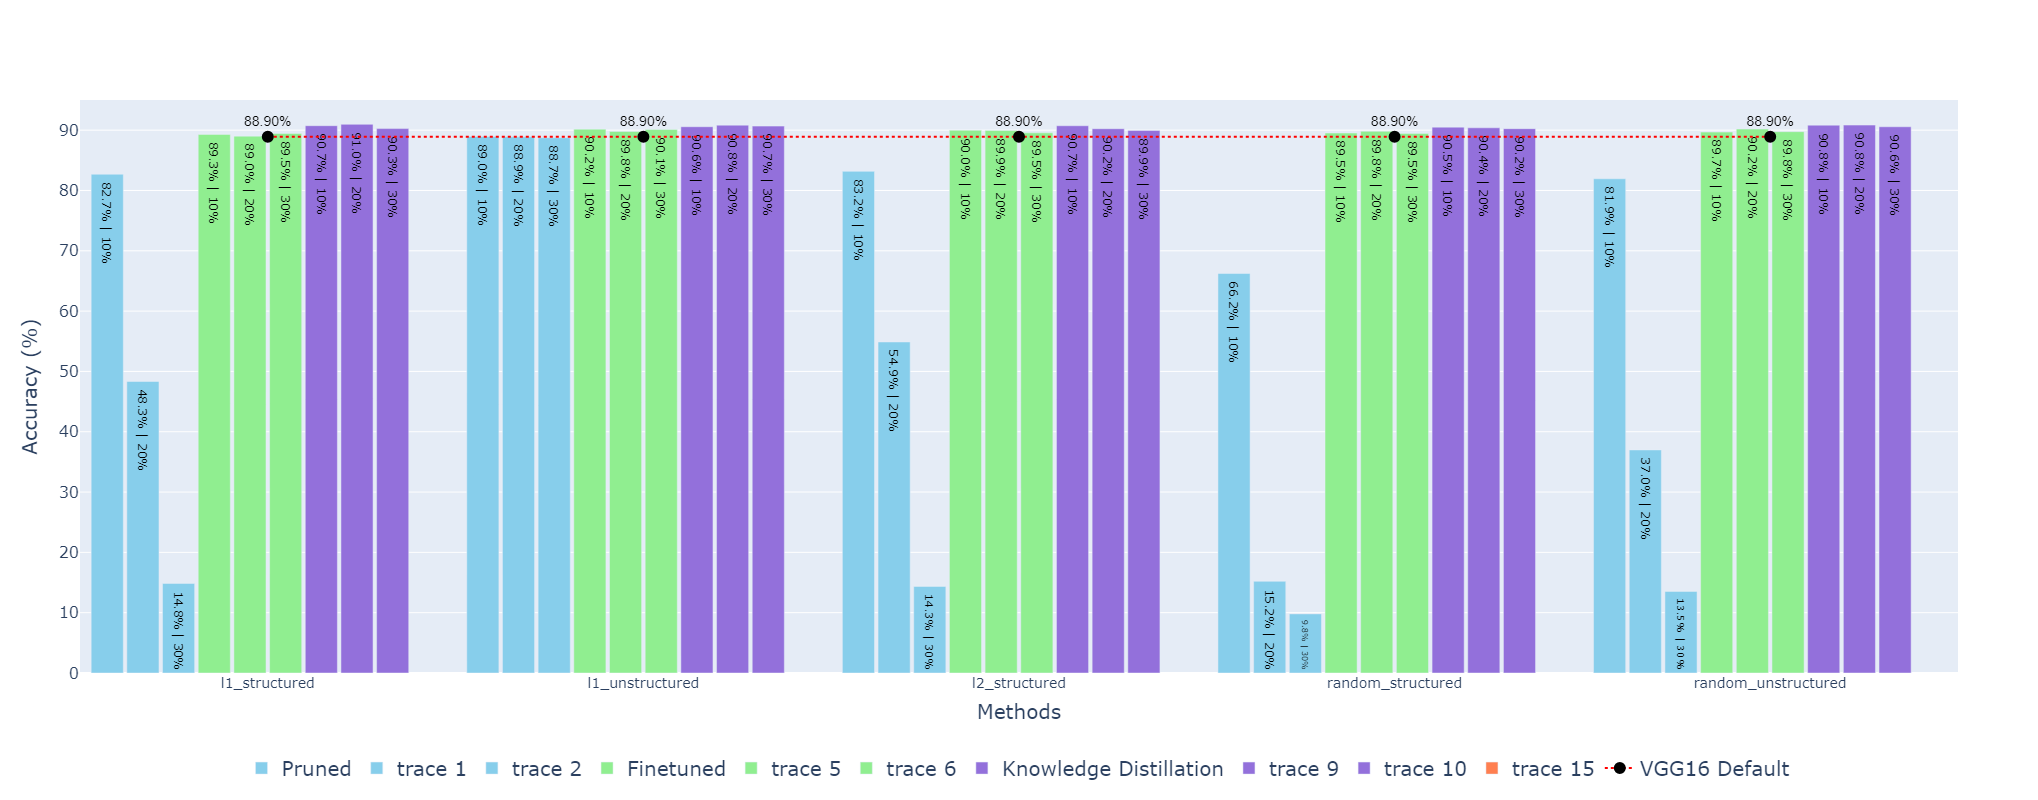

In [683]:
methods_order = ['l1_structured', 'l1_unstructured', 'l2_structured', 'random_structured', 'random_unstructured']
combined_df['method'] = pd.Categorical(combined_df['method'], categories=methods_order, ordered=True)
combined_df = combined_df.sort_values('method')

name_map_methods = {
    "default": "VGG16 Default",
    "l1_structured": "L1 Structured",
    "l1_unstructured": "L1 Unstructured",
    "l2_structured": "L2 Structured",
    "random_structured": "Random Structured",
    "random_unstructured": "Random Unstructured"
}

name_map = {
    "kd": "Knowledge Distillation",
    "pruned": "Pruned",
    "finetuned": "Finetuned",
    "base": "VGG16 Default"
}

colors = {
    "pruned": 'skyblue',
    "finetuned": 'lightgreen',
    "kd": 'mediumpurple'
}

unique_combinations = combined_df[['method', 'pruning_percentage']].drop_duplicates()
color_palette = px.colors.qualitative.Plotly
color_map = {f"{row['method']}_{row['pruning_percentage']}": color_palette[i % len(color_palette)]
             for i, row in enumerate(unique_combinations.to_dict(orient='records'))}

fig = go.Figure()

legend_items = set()
for key in combined_df['key'].unique():
    key_data = combined_df[combined_df['key'] == key]
    for pruning_percentage in combined_df['pruning_percentage'].unique():
        percentage_data = key_data[key_data['pruning_percentage'] == pruning_percentage]
        
        if 'base' not in percentage_data['method'].values:
            legend_name = name_map.get(key, key) if key not in legend_items else None
            legend_items.add(key)
            
            fig.add_trace(go.Bar(
                x=percentage_data['method'],
                y=percentage_data['accuracy'],
                name=legend_name,
                marker_color=colors.get(key, 'coral'),
                text=[f' {acc:.1f}% | {float(pruning_percentage) * 100:.0f}%' for acc in percentage_data['accuracy']],
                textposition='inside',
                textfont=dict(size=12, color='black'),
            ))

base_data = combined_df[combined_df['key'] == 'base']
base_accuracy = base_data['accuracy'].mean()

fig.add_trace(go.Scatter(
    x=methods_order,
    y=[base_accuracy] * len(methods_order),
    mode='lines+markers+text',
    name=name_map.get('base', 'Base Model Accuracy'),
    line=dict(
        color='red',
        dash='dot',
        width=2
    ),
    marker=dict(
        symbol='circle',
        size=10,
        color='black',
        line=dict(width=2, color='black')
    ),
    text=[f"{base_accuracy:.2f}%" for _ in methods_order],
    textposition="top center",
    textfont=dict(size=14, color='black', family="Arial"),
    hoverinfo='x+y',
    opacity=1.0
))

fig.update_layout(
    yaxis=dict(
        title="Accuracy (%)",
        title_font=dict(size=20),
        range=[0, 95],
        tickfont=dict(size=16),
    ),
    xaxis=dict(
        title="Methods",
        tickangle=0,
        categoryorder="array",
        categoryarray=methods_order,
        tickvals=methods_order,
        title_font=dict(size=20),
        tickfont=dict(size=14),
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.2,
        xanchor='center',
        x=0.5,
        font=dict(size=20),
        bgcolor='rgba(255,255,255,0.8)'
    ),
    font=dict(size=20),
    width=2000,
    height=800,
    barmode='group',
    bargap=0.05,
    bargroupgap=0.1
)

fig.show()

## Plot models predictions

In [317]:
def denormalize(img, mean, std):
    img = img.clone().detach().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def plot_predictions(models, data_loader, mean, std, num_images=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)
    
    # Criar a figura com layout ajustado
    fig, axes = plt.subplots(num_images + 1, len(models) + 1, figsize=(15, (num_images + 1) * 2))
    
    # Configurar os títulos das colunas na primeira linha
    column_titles = ["True Labels"] + list(models.keys())
    for col, title in enumerate(column_titles):
        axes[0, col].axis('off')  # Esconder os eixos
        axes[0, col].set_title(title, fontsize=12, fontweight='bold')  # Adicionar título
    
    # Preencher as imagens e rótulos nas linhas seguintes
    for idx, (img, label) in enumerate(zip(images, labels), start=1):
        # Denormalizar e converter a imagem para formato visualizável
        img_denormalized = denormalize(img, mean, std)
        img_np = np.clip(np.transpose(img_denormalized.numpy(), (1, 2, 0)), 0, 1)
        
        # Exibir a imagem e o rótulo verdadeiro na primeira coluna
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"{label.item()}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # Checar e exibir os resultados dos modelos nas demais colunas
        for j, (name, model) in enumerate(models.items(), start=1):
            model.to(device)
            model.eval()
            with torch.no_grad():
                logits = model(img.unsqueeze(0).to(device))
                pred = logits.argmax(dim=1).item()
            
            # Checar se há erro e configurar título ou destaque
            is_error = pred != label.item()
            title = f"Error ({pred})" if is_error else f"{pred}"
            
            # Adicionar imagem e título
            axes[idx, j].imshow(img_np)
            axes[idx, j].set_title(title, color='red' if is_error else 'black', fontsize=10)
            axes[idx, j].axis('off')
    
    # Ajustar o espaçamento vertical entre as linhas
    plt.subplots_adjust(hspace=0.3)  # Reduzir o espaço vertical
    
    plt.tight_layout()
    plt.show()



In [311]:
def plot_predictions(models, data_loader, mean, std, num_images=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)
    
    # Criar a figura com layout ajustado
    fig, axes = plt.subplots(num_images + 1, len(models) + 1, figsize=(15, (num_images + 1) * 2))
    
    # Configurar os títulos das colunas na primeira linha
    column_titles = ["True Labels"] + list(models.keys())
    for col, title in enumerate(column_titles):
        axes[1, col].axis('off')  # Esconder os eixos
        axes[1, col].set_title(title, fontsize=12, fontweight='bold')  # Adicionar título
    
    # Preencher as imagens e rótulos nas linhas seguintes
    for idx, (img, label) in enumerate(zip(images, labels), start=1):
        # Denormalizar e converter a imagem para formato visualizável
        img_denormalized = denormalize(img, mean, std)
        img_np = np.clip(np.transpose(img_denormalized.numpy(), (1, 2, 0)), 0, 1)
        
        # Exibir a imagem e o rótulo verdadeiro na primeira coluna
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"{label.item()}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # Checar e exibir os resultados dos modelos nas demais colunas
        for j, (name, model) in enumerate(models.items(), start=1):
            model.to(device)
            model.eval()
            with torch.no_grad():
                logits = model(img.unsqueeze(0).to(device))
                pred = logits.argmax(dim=1).item()
            
            # Checar se há erro e configurar título ou destaque
            is_error = pred != label.item()
            title = f"Error ({pred})" if is_error else f"{pred}"
            
            # Adicionar imagem e título
            axes[idx, j].imshow(img_np)
            axes[idx, j].set_title(title, color='red' if is_error else 'black', fontsize=10)
            axes[idx, j].axis('off')
    
    plt.tight_layout()
    plt.show()


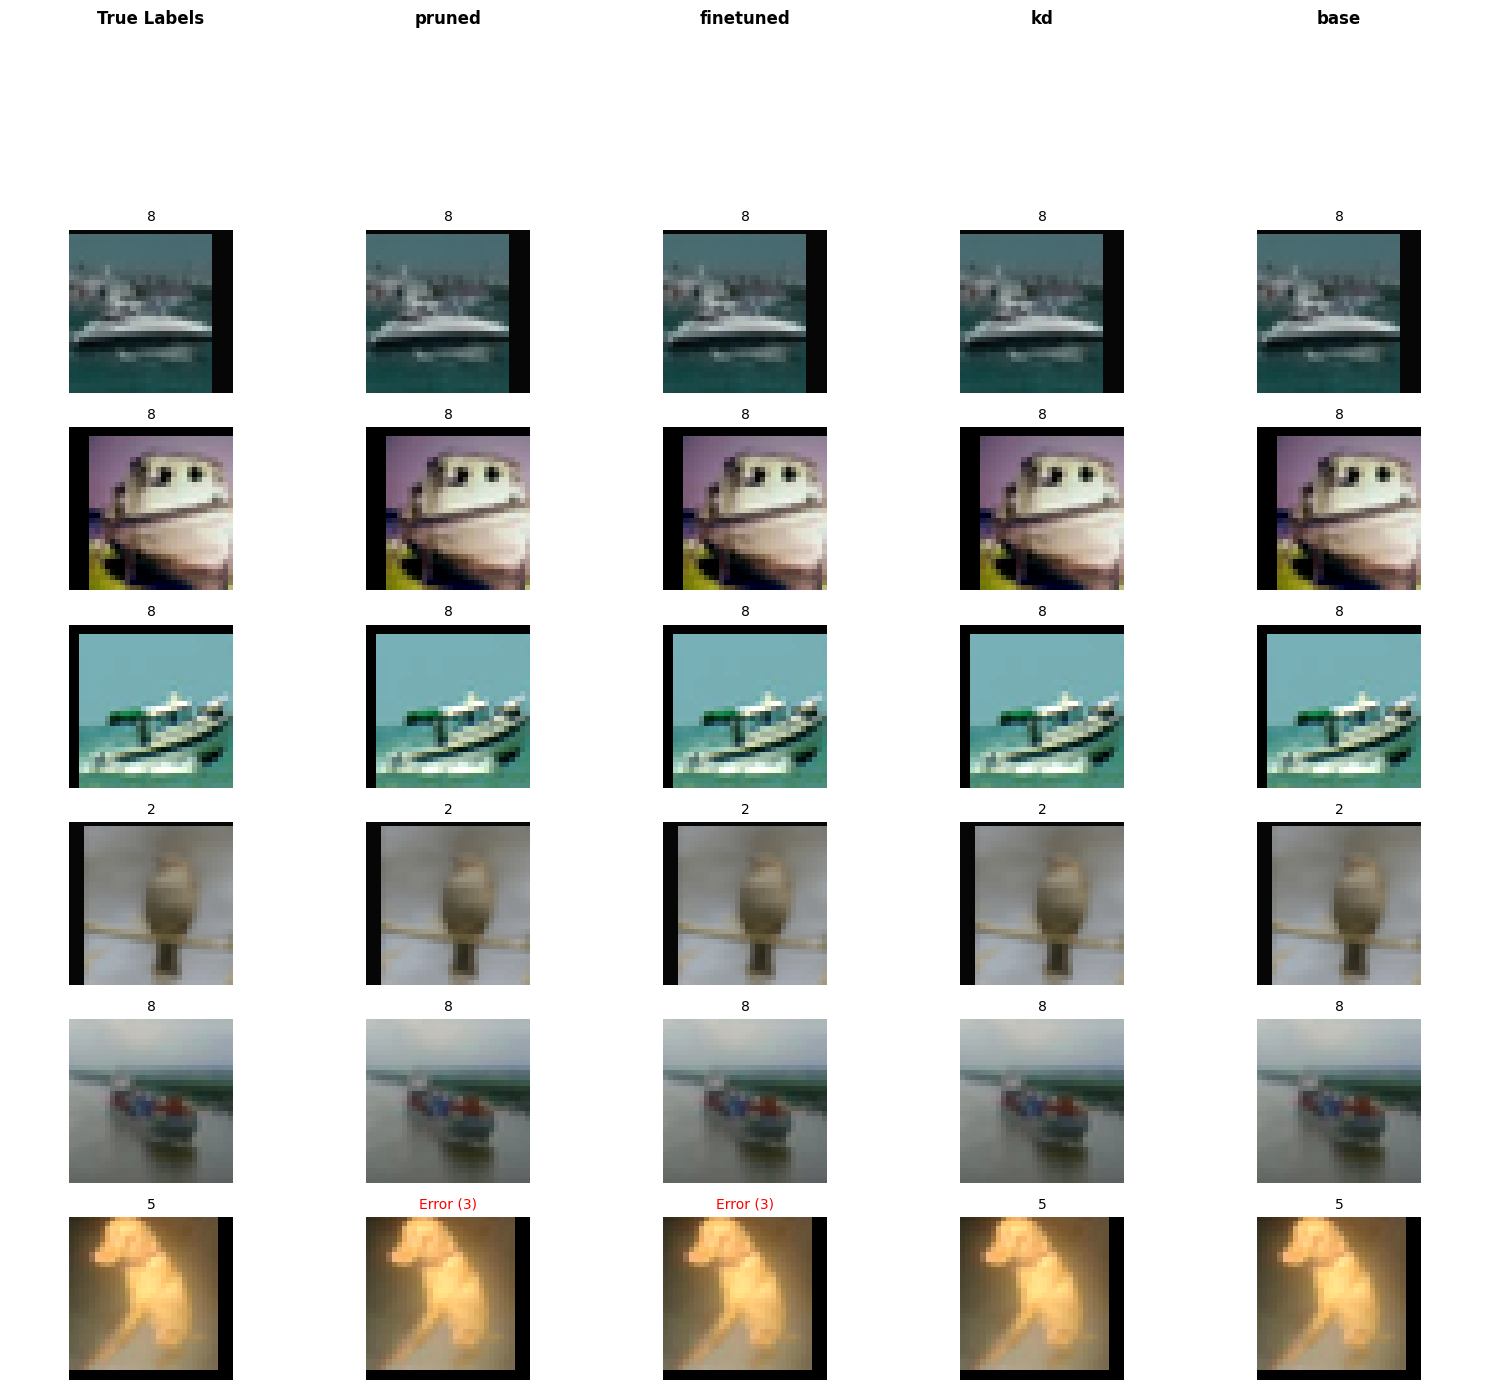

In [318]:

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

base_model = VGG16(num_classes=10)
base_model.load_state_dict(torch.load('model_t2.h5'))
base_model = base_model.to('cuda')

models_dict = {
    'pruned': load_model('models_pruned_with_mask/vgg16_pruned_allConv2dlayers_l1_structured_0.1_frozen.pth').to('cuda'),
    'finetuned': load_model('models/pruning_finetuned/vgg16_pruned_allConv2dlayers_l1_structured_0.2_finetuned_frozen.pth').to('cuda'),
    'kd': load_model('models_pruned_with_mask/vgg16_pruned_allConv2dlayers_l1_structured_0.2_kd_frozen.pth').to('cuda'),
    'base': base_model
}
plot_predictions(models_dict, val_loader, mean, std, num_images=6)
